# PROYECTO UGR - v3

## Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import imblearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,precision_score
from sklearn.preprocessing import FunctionTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost

from sklearn.metrics import plot_confusion_matrix

from imblearn.over_sampling import ADASYN,RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler,NeighbourhoodCleaningRule,TomekLinks
from imblearn.combine import SMOTETomek,SMOTEENN
from imblearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore", category=Warning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

## Cargar y unir los Dataframes

### Carga, unión y preprocesado inicial

In [2]:
# CSV original con los datos 2008 - 2021
df = pd.read_csv('Datos/Datos Empresas Turismo.xlsx - Datos.csv',na_values='n.d.',index_col=False,decimal=",", thousands='.')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)


df_anuales = df.columns[df.columns.str.contains('2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|2020|2021',case = False)]
df_anuales = df_anuales.drop('Código primario CNAE 2009')


for columna in df_anuales:
    if(df[columna].dtype == 'object'):
        df[columna] = df[columna].astype('str').str.replace(',', '.')
        df[columna] = pd.to_numeric(df[columna],errors='coerce')


df = df.drop(['Código NIF','Dirección web','Presidente','Código primario CNAE 2009', 'Director ejecutivo','Nombre marca','Nombre auditor','Opinión auditor','Localidad','Salvedades'],axis=1)

In [3]:
# CSV complementario 1 - datos de 2000-2007
df_1 = pd.read_csv('Datos/Sabi_Export_CNAE55_1.csv',sep=';',na_values='n.d.',index_col=False,decimal=",", thousands='.',encoding='utf-8')
df_1.drop(df_1.columns[df_1.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df_1.drop(df_1.columns[df_1.columns.str.contains('Nombre.1',case = False)],axis = 1, inplace = True)

df_anuales = df_1.columns[df_1.columns.str.contains('2000|2001|2002|2003|2004|2005|2006|2007',case = False)]


for columna in df_anuales:
    if(df_1[columna].dtype == 'object'):
        df_1[columna] = df_1[columna].astype('str').str.replace(',', '.')
        df_1[columna] = pd.to_numeric(df_1[columna],errors='coerce')

In [4]:
# CSV complementario 2 - datos de 2000-2007
df_2 = pd.read_csv('Datos/Sabi_Export_CNAE55_2.csv',sep=';',na_values='n.d.',index_col=False,decimal=",", thousands='.',encoding='utf-8')
df_2.drop(df_2.columns[df_2.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df_2.drop(df_2.columns[df_2.columns.str.contains('Nombre.1',case = False)],axis = 1, inplace = True)

df_anuales = df_2.columns[df_2.columns.str.contains('2000|2001|2002|2003|2004|2005|2006|2007',case = False)]

for columna in df_anuales:
    if(df_2[columna].dtype == 'object'):
        df_2[columna] = df_2[columna].astype('str').str.replace(',', '.')
        df_2[columna] = pd.to_numeric(df_2[columna],errors='coerce')


Concatenamos los dos CSV complementarios y los ordenamos por 'Nombre' en orden alfabético:

In [5]:
df_nuevo = pd.concat([df_1,df_2],ignore_index=True,copy=True)

In [6]:
df_nuevo = df_nuevo.sort_values('Nombre',ignore_index=True)
df_nuevo

,Nombre,Código NIF,Ultimo año disponible,"Cotiza, no cotiza, cotizó",Indicator de\nIndependencia BvD,Rentabilidad sobre recursos propios (%)\n%\n2007,Rentabilidad sobre recursos propios (%)\n%\n2006,Rentabilidad sobre recursos propios (%)\n%\n2005,Rentabilidad sobre recursos propios (%)\n%\n2004,Rentabilidad sobre recursos propios (%)\n%\n2003,Rentabilidad sobre recursos propios (%)\n%\n2002,Rentabilidad sobre recursos propios (%)\n%\n2001,Rentabilidad sobre recursos propios (%)\n%\n2000,Rentabilidad sobre capital empleado (%)\n%\n2007,Rentabilidad sobre capital empleado (%)\n%\n2006,Rentabilidad sobre capital empleado (%)\n%\n2005,Rentabilidad sobre capital empleado (%)\n%\n2004,Rentabilidad sobre capital empleado (%)\n%\n2003,Rentabilidad sobre capital empleado (%)\n%\n2002,Rentabilidad sobre capital empleado (%)\n%\n2001,Rentabilidad sobre capital empleado (%)\n%\n2000,Rentabilidad sobre el activo total (%)\n%\n2007,Rentabilidad sobre el activo total (%)\n%\n2006,Rentabilidad sobre el activo total (%)\n%\n2005,Rentabilidad sobre el activo total (%)\n%\n2004,Rentabilidad sobre el activo total (%)\n%\n2003,Rentabilidad sobre el activo total (%)\n%\n2002,Rentabilidad sobre el activo total (%)\n%\n2001,Rentabilidad sobre el activo total (%)\n%\n2000,Margen de beneficio (%)\n%\n2007,Margen de beneficio (%)\n%\n2006,Margen de beneficio (%)\n%\n2005,Margen de beneficio (%)\n%\n2004,Margen de beneficio (%)\n%\n2003,Margen de beneficio (%)\n%\n2002,Margen de beneficio (%)\n%\n2001,Margen de beneficio (%)\n%\n2000,Rotación de activos netos\n%\n2007,Rotación de activos netos\n%\n2006,Rotación de activos netos\n%\n2005,Rotación de activos netos\n%\n2004,Rotación de activos netos\n%\n2003,Rotación de activos netos\n%\n2002,Rotación de activos netos\n%\n2001,Rotación de activos netos\n%\n2000,Ratio de cobertura de intereses\n%\n2007,Ratio de cobertura de intereses\n%\n2006,Ratio de cobertura de intereses\n%\n2005,Ratio de cobertura de intereses\n%\n2004,Ratio de cobertura de intereses\n%\n2003,Ratio de cobertura de intereses\n%\n2002,Ratio de cobertura de intereses\n%\n2001,Ratio de cobertura de intereses\n%\n2000,Rotación de las existencias\n%\n2007,Rotación de las existencias\n%\n2006,Rotación de las existencias\n%\n2005,Rotación de las existencias\n%\n2004,Rotación de las existencias\n%\n2003,Rotación de las existencias\n%\n2002,Rotación de las existencias\n%\n2001,Rotación de las existencias\n%\n2000,Período de cobro (días)\ndías\n2007,Período de cobro (días)\ndías\n2006,Período de cobro (días)\ndías\n2005,Período de cobro (días)\ndías\n2004,Período de cobro (días)\ndías\n2003,Período de cobro (días)\ndías\n2002,Período de cobro (días)\ndías\n2001,Período de cobro (días)\ndías\n2000,Período de crédito (días)\ndías\n2007,Período de crédito (días)\ndías\n2006,Período de crédito (días)\ndías\n2005,Período de crédito (días)\ndías\n2004,Período de crédito (días)\ndías\n2003,Período de crédito (días)\ndías\n2002,Período de crédito (días)\ndías\n2001,Período de crédito (días)\ndías\n2000,Costes de los trabajadores / Ingresos de explotación (%)\n%\n2007,Costes de los trabajadores / Ingresos de explotación (%)\n%\n2006,Costes de los trabajadores / Ingresos de explotación (%)\n%\n2005,Costes de los trabajadores / Ingresos de explotación (%)\n%\n2004,Costes de los trabajadores / Ingresos de explotación (%)\n%\n2003,Costes de los trabajadores / Ingresos de explotación (%)\n%\n2002,Costes de los trabajadores / Ingresos de explotación (%)\n%\n2001,Costes de los trabajadores / Ingresos de explotación (%)\n%\n2000,Coste medio de los empleados\nmil\n2007,Coste medio de los empleados\nmil\n2006,Coste medio de los empleados\nmil\n2005,Coste medio de los empleados\nmil\n2004,Coste medio de los empleados\nmil\n2003,Coste medio de los empleados\nmil\n2002,Coste medio de los empleados\nmil\n2001,Coste medio de los empleados\nmil\n2000,Capital circulante por empleado\nmil\n2007,Capital circulante por empleado\nmil\n2006,Capital circulante por empleado\nmil\

In [7]:
df=df.sort_values('Nombre',ignore_index=True)
df

,Nombre,Código consolidación,Ultimo año disponible,Dirección marketeable,Forma jurídica detallada,Fecha constitución,Estado detallado,Fecha cambio estado,Tipo cuentas dispon.,Ultimo número empleados,No of companies in corporate group,Número de participadas,Fecha boletín,Estado,Rentabilidad sobre recursos propios (%)\n%\n2021,Rentabilidad sobre recursos propios (%)\n%\n2020,Rentabilidad sobre recursos propios (%)\n%\n2019,Rentabilidad sobre recursos propios (%)\n%\n2018,Rentabilidad sobre recursos propios (%)\n%\n2017,Rentabilidad sobre recursos propios (%)\n%\n2016,Rentabilidad sobre recursos propios (%)\n%\n2015,Rentabilidad sobre recursos propios (%)\n%\n2014,Rentabilidad sobre recursos propios (%)\n%\n2013,Rentabilidad sobre recursos propios (%)\n%\n2012,Rentabilidad sobre recursos propios (%)\n%\n2011,Rentabilidad sobre recursos propios (%)\n%\n2010,Rentabilidad sobre recursos propios (%)\n%\n2009,Rentabilidad sobre recursos propios (%)\n%\n2008,Rentabilidad sobre capital empleado (%)\n%\n2021,Rentabilidad sobre capital empleado (%)\n%\n2020,Rentabilidad sobre capital empleado (%)\n%\n2019,Rentabilidad sobre capital empleado (%)\n%\n2018,Rentabilidad sobre capital empleado (%)\n%\n2017,Rentabilidad sobre capital empleado (%)\n%\n2016,Rentabilidad sobre capital empleado (%)\n%\n2015,Rentabilidad sobre capital empleado (%)\n%\n2014,Rentabilidad sobre capital empleado (%)\n%\n2013,Rentabilidad sobre capital empleado (%)\n%\n2012,Rentabilidad sobre capital empleado (%)\n%\n2011,Rentabilidad sobre capital empleado (%)\n%\n2010,Rentabilidad sobre capital empleado (%)\n%\n2009,Rentabilidad sobre capital empleado (%)\n%\n2008,Rentabilidad sobre el activo total (%)\n%\n2021,Rentabilidad sobre el activo total (%)\n%\n2020,Rentabilidad sobre el activo total (%)\n%\n2019,Rentabilidad sobre el activo total (%)\n%\n2018,Rentabilidad sobre el activo total (%)\n%\n2017,Rentabilidad sobre el activo total (%)\n%\n2016,Rentabilidad sobre el activo total (%)\n%\n2015,Rentabilidad sobre el activo total (%)\n%\n2014,Rentabilidad sobre el activo total (%)\n%\n2013,Rentabilidad sobre el activo total (%)\n%\n2012,Rentabilidad sobre el activo total (%)\n%\n2011,Rentabilidad sobre el activo total (%)\n%\n2010,Rentabilidad sobre el activo total (%)\n%\n2009,Rentabilidad sobre el activo total (%)\n%\n2008,Margen de beneficio (%)\n%\n2021,Margen de beneficio (%)\n%\n2020,Margen de beneficio (%)\n%\n2019,Margen de beneficio (%)\n%\n2018,Margen de beneficio (%)\n%\n2017,Margen de beneficio (%)\n%\n2016,Margen de beneficio (%)\n%\n2015,Margen de beneficio (%)\n%\n2014,Margen de beneficio (%)\n%\n2013,Margen de beneficio (%)\n%\n2012,Margen de beneficio (%)\n%\n2011,Margen de beneficio (%)\n%\n2010,Margen de beneficio (%)\n%\n2009,Margen de beneficio (%)\n%\n2008,Rotación de activos netos\n%\n2021,Rotación de activos netos\n%\n2020,Rotación de activos netos\n%\n2019,Rotación de activos netos\n%\n2018,Rotación de activos netos\n%\n2017,Rotación de activos netos\n%\n2016,Rotación de activos netos\n%\n2015,Rotación de activos netos\n%\n2014,Rotación de activos netos\n%\n2013,Rotación de activos netos\n%\n2012,Rotación de activos netos\n%\n2011,Rotación de activos netos\n%\n2010,Rotación de activos netos\n%\n2009,Rotación de activos netos\n%\n2008,Ratio de cobertura de intereses\n%\n2021,Ratio de cobertura de intereses\n%\n2020,Ratio de cobertura de intereses\n%\n2019,Ratio de cobertura de intereses\n%\n2018,Ratio de cobertura de intereses\n%\n2017,Ratio de cobertura de intereses\n%\n2016,Ratio de cobertura de intereses\n%\n2015,Ratio de cobertura de intereses\n%\n2014,Ratio de cobertura de intereses\n%\n2013,Ratio de cobertura de intereses\n%\n2012,Ratio de cobertura de intereses\n%\n2011,Ratio de cobertura de intereses\n%\n2010,Ratio de cobertura de intereses\n%\n2009,Ratio de cobertura de intereses\n%\n2008,Rotación de las existencias\n%\n2021,Rotación de las existencias\n%\n2020,Rotación de las existencias\n%\n2019,Rotación de las existencias\n%\n2018,Rota

Unimos el dataframe del .csv original con el dataframe complementario sobre la columna 'Nombre'. Un JOIN nos deja con menos columnas que un LEFT JOIN (siendo LEFT el csv original), lo que quiere decir que hemos perdido datos:

In [8]:
df_merged = pd.merge(df,df_nuevo,on='Nombre')
df_merged_left = pd.merge(df,df_nuevo,on='Nombre',how='left')

In [9]:
i=df_merged[df_merged['Nombre']=='CAMPING LA SIRENA SOCIEDAD ANONIMA']
print(i.index)
i=df_merged_left[df_merged_left['Nombre']=='CAMPING LA SIRENA SOCIEDAD ANONIMA']
print(i.index)

i=0
j=0
diferencias = 0
while i < 4942:
    if df_merged.iloc[i].Nombre != df_merged_left.iloc[j].Nombre:
        # print(j, df_merged_left.iloc[j].Nombre)
        j+=1
        diferencias += 1
    else:
        i+=1
        j+=1

print('Faltan',diferencias,'empresas que si estaban en el .csv original.')

Int64Index([], dtype='int64')
Int64Index([787], dtype='int64')
Faltan 219 empresas que si estaban en el .csv original.


Eliminamos aquellas columnas no utiles, tanto las que tienen demasiados datos vacios como las no anualizadas:

In [10]:
df_merged

,Nombre,Código consolidación,Ultimo año disponible_x,Dirección marketeable,Forma jurídica detallada,Fecha constitución,Estado detallado,Fecha cambio estado,Tipo cuentas dispon.,Ultimo número empleados,No of companies in corporate group,Número de participadas,Fecha boletín,Estado,Rentabilidad sobre recursos propios (%)\n%\n2021,Rentabilidad sobre recursos propios (%)\n%\n2020,Rentabilidad sobre recursos propios (%)\n%\n2019,Rentabilidad sobre recursos propios (%)\n%\n2018,Rentabilidad sobre recursos propios (%)\n%\n2017,Rentabilidad sobre recursos propios (%)\n%\n2016,Rentabilidad sobre recursos propios (%)\n%\n2015,Rentabilidad sobre recursos propios (%)\n%\n2014,Rentabilidad sobre recursos propios (%)\n%\n2013,Rentabilidad sobre recursos propios (%)\n%\n2012,Rentabilidad sobre recursos propios (%)\n%\n2011,Rentabilidad sobre recursos propios (%)\n%\n2010,Rentabilidad sobre recursos propios (%)\n%\n2009,Rentabilidad sobre recursos propios (%)\n%\n2008,Rentabilidad sobre capital empleado (%)\n%\n2021,Rentabilidad sobre capital empleado (%)\n%\n2020,Rentabilidad sobre capital empleado (%)\n%\n2019,Rentabilidad sobre capital empleado (%)\n%\n2018,Rentabilidad sobre capital empleado (%)\n%\n2017,Rentabilidad sobre capital empleado (%)\n%\n2016,Rentabilidad sobre capital empleado (%)\n%\n2015,Rentabilidad sobre capital empleado (%)\n%\n2014,Rentabilidad sobre capital empleado (%)\n%\n2013,Rentabilidad sobre capital empleado (%)\n%\n2012,Rentabilidad sobre capital empleado (%)\n%\n2011,Rentabilidad sobre capital empleado (%)\n%\n2010,Rentabilidad sobre capital empleado (%)\n%\n2009,Rentabilidad sobre capital empleado (%)\n%\n2008,Rentabilidad sobre el activo total (%)\n%\n2021,Rentabilidad sobre el activo total (%)\n%\n2020,Rentabilidad sobre el activo total (%)\n%\n2019,Rentabilidad sobre el activo total (%)\n%\n2018,Rentabilidad sobre el activo total (%)\n%\n2017,Rentabilidad sobre el activo total (%)\n%\n2016,Rentabilidad sobre el activo total (%)\n%\n2015,Rentabilidad sobre el activo total (%)\n%\n2014,Rentabilidad sobre el activo total (%)\n%\n2013,Rentabilidad sobre el activo total (%)\n%\n2012,Rentabilidad sobre el activo total (%)\n%\n2011,Rentabilidad sobre el activo total (%)\n%\n2010,Rentabilidad sobre el activo total (%)\n%\n2009,Rentabilidad sobre el activo total (%)\n%\n2008,Margen de beneficio (%)\n%\n2021,Margen de beneficio (%)\n%\n2020,Margen de beneficio (%)\n%\n2019,Margen de beneficio (%)\n%\n2018,Margen de beneficio (%)\n%\n2017,Margen de beneficio (%)\n%\n2016,Margen de beneficio (%)\n%\n2015,Margen de beneficio (%)\n%\n2014,Margen de beneficio (%)\n%\n2013,Margen de beneficio (%)\n%\n2012,Margen de beneficio (%)\n%\n2011,Margen de beneficio (%)\n%\n2010,Margen de beneficio (%)\n%\n2009,Margen de beneficio (%)\n%\n2008,Rotación de activos netos\n%\n2021,Rotación de activos netos\n%\n2020,Rotación de activos netos\n%\n2019,Rotación de activos netos\n%\n2018,Rotación de activos netos\n%\n2017,Rotación de activos netos\n%\n2016,Rotación de activos netos\n%\n2015,Rotación de activos netos\n%\n2014,Rotación de activos netos\n%\n2013,Rotación de activos netos\n%\n2012,Rotación de activos netos\n%\n2011,Rotación de activos netos\n%\n2010,Rotación de activos netos\n%\n2009,Rotación de activos netos\n%\n2008,Ratio de cobertura de intereses\n%\n2021,Ratio de cobertura de intereses\n%\n2020,Ratio de cobertura de intereses\n%\n2019,Ratio de cobertura de intereses\n%\n2018,Ratio de cobertura de intereses\n%\n2017,Ratio de cobertura de intereses\n%\n2016,Ratio de cobertura de intereses\n%\n2015,Ratio de cobertura de intereses\n%\n2014,Ratio de cobertura de intereses\n%\n2013,Ratio de cobertura de intereses\n%\n2012,Ratio de cobertura de intereses\n%\n2011,Ratio de cobertura de intereses\n%\n2010,Ratio de cobertura de intereses\n%\n2009,Ratio de cobertura de intereses\n%\n2008,Rotación de las existencias\n%\n2021,Rotación de las existencias\n%\n2020,Rotación de las existencias\n%\n2019,Rotación de las existencias\n%\n2018,Ro

In [11]:
df_merged = df_merged.drop(['Código consolidación','Dirección marketeable','Forma jurídica detallada','Estado detallado','Tipo cuentas dispon.','Ultimo número empleados',
                            'No of companies in corporate group','Número de participadas','Fecha boletín','Estado','Incidencias Judiciales','Incidencias Judiciales, primera',
                            'Incidencias Judiciales, última','Reclamaciones administrativas','Reclamaciones administrativas, primera','Reclamaciones administrativas, última',
                            'Número de miembros actuales de las juntas directivas y de gestión','Número de miembros anteriores\nde las juntas y gestión','DM\nTambién un accionista',
                            'DM\nNivel de responsabilidad','Cotiza, no cotiza, cotizó','Indicator de\nIndependencia BvD','Código NIF','Ultimo año disponible_y',
                            'Remuneraciones Auditor\nEUR\n2008','Remuneraciones Auditor\nEUR\n2009','Remuneraciones Auditor\nEUR\n2010','Remuneraciones Auditor\nEUR\n2011',
                            'Remuneraciones Auditor\nEUR\n2012','Remuneraciones Auditor\nEUR\n2013','Remuneraciones Auditor\nEUR\n2014','Remuneraciones Auditor\nEUR\n2015',
                            'Remuneraciones Auditor\nEUR\n2016','Remuneraciones Auditor\nEUR\n2017','Remuneraciones Auditor\nEUR\n2018','Remuneraciones Auditor\nEUR\n2019',
                            'Remuneraciones Auditor\nEUR\n2020','Remuneraciones Auditor\nEUR\n2021','Remuneración Consejo\nEUR\n2008','Remuneración Consejo\nEUR\n2009',
                            'Remuneración Consejo\nEUR\n2010','Remuneración Consejo\nEUR\n2011','Remuneración Consejo\nEUR\n2012','Remuneración Consejo\nEUR\n2013',
                            'Remuneración Consejo\nEUR\n2014','Remuneración Consejo\nEUR\n2015','Remuneración Consejo\nEUR\n2016','Remuneración Consejo\nEUR\n2017',
                            'Remuneración Consejo\nEUR\n2018','Remuneración Consejo\nEUR\n2019','Remuneración Consejo\nEUR\n2020','Remuneración Consejo\nEUR\n2021',
                            'Gastos Servicios Profesionales\nEUR\n2008','Gastos Servicios Profesionales\nEUR\n2009','Gastos Servicios Profesionales\nEUR\n2010',
                            'Gastos Servicios Profesionales\nEUR\n2011','Gastos Servicios Profesionales\nEUR\n2012','Gastos Servicios Profesionales\nEUR\n2013',
                            'Gastos Servicios Profesionales\nEUR\n2014','Gastos Servicios Profesionales\nEUR\n2015','Gastos Servicios Profesionales\nEUR\n2016',
                            'Gastos Servicios Profesionales\nEUR\n2017','Gastos Servicios Profesionales\nEUR\n2018','Gastos Servicios Profesionales\nEUR\n2019',
                            'Gastos Servicios Profesionales\nEUR\n2020','Gastos Servicios Profesionales\nEUR\n2021','Gastos Servicios Publicidad\nEUR\n2008',
                            'Gastos Servicios Publicidad\nEUR\n2009','Gastos Servicios Publicidad\nEUR\n2010','Gastos Servicios Publicidad\nEUR\n2011','Gastos Servicios Publicidad\nEUR\n2012',
                            'Gastos Servicios Publicidad\nEUR\n2013','Gastos Servicios Publicidad\nEUR\n2014','Gastos Servicios Publicidad\nEUR\n2015',
                            'Gastos Servicios Publicidad\nEUR\n2016','Gastos Servicios Publicidad\nEUR\n2017','Gastos Servicios Publicidad\nEUR\n2018','Gastos Servicios Publicidad\nEUR\n2019',
                            'Gastos Servicios Publicidad\nEUR\n2020','Gastos Servicios Publicidad\nEUR\n2021'],axis=1)

Renombramos unas columnas que no eran congruentes con el nombre de sus contrapartes de 2008-2021:

In [12]:
df_merged = df_merged.rename(columns={'Total activo\nEUR\n2002': 'Total Activo\nEUR\n2002',
                                      'Total activo\nEUR\n2003': 'Total Activo\nEUR\n2003',
                                      'Total activo\nEUR\n2004': 'Total Activo\nEUR\n2004',
                                      'Total activo\nEUR\n2005': 'Total Activo\nEUR\n2005',
                                      'Total activo\nEUR\n2006': 'Total Activo\nEUR\n2006',
                                      'Total activo\nEUR\n2007': 'Total Activo\nEUR\n2007'})

Rellenamos dos empresas que no tenian datos de fecha de creación:

In [13]:
df_merged.iloc[201,2]='01/01/2002'
df_merged.iloc[3002,2]='01/01/2010'

### Estudio del número de años disponibles

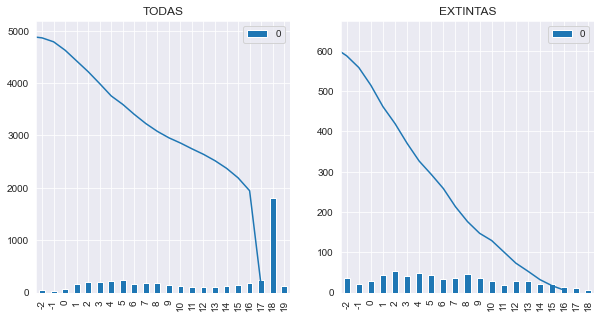

In [14]:
casos = ['TODAS','EXTINTAS']

fig,axs = plt.subplots(1,2,figsize=(10,5))

for caso in casos:

    df_a_usar = df_merged
    indice_1 = 2
    indice_2 = 1

    if caso == 'EXTINTAS':
        df_merged['Y'] = np.where(df_merged['Nombre'].str.contains('EXTINGUIDA'),1,0)
        df_merged.insert(0, 'Y', df_merged.pop('Y'))
        df_extintas = df_merged[df_merged['Y']==1]
        df_extintas.reset_index(inplace=True,drop=True)
        indice_1 = 3
        indice_2 = 2
        df_a_usar = df_extintas

    aux_list = []

    for i in range(len(df_a_usar)):
        anio_constitucion = int(df_a_usar.iloc[i,indice_1][-4:])
        ultimo_anio = int(df_a_usar.iloc[i,indice_2][-4:])
        if(anio_constitucion < 2002):
            anio_constitucion = 2002
        aux_list.append(ultimo_anio-anio_constitucion)

    aux_list.sort()
    letter_counts = Counter(aux_list)

    df = pd.DataFrame.from_dict(letter_counts, orient='index')
    df.plot(kind='bar',ax=axs[indice_2-1])


    n_anios_disponibles = letter_counts.keys()
    n_empresas = letter_counts.values()

    total = 0

    anios = []
    empresas = []

    for n_anios,n_empresa in list(zip(n_anios_disponibles,n_empresas))[::-1]:
        total += n_empresa
        anios.append(n_anios)
        empresas.append(total)
        
    anios.reverse()
    empresas.reverse()

    axs[indice_2-1].plot(anios,empresas)
    axs[indice_2-1].title.set_text(caso)

plt.show()

Los graficos de barras representan cuantas empresas existen con el nº indicado en el eje x de años de información disponible. El grafico de línea es el número acumulado de empresas que tienen como minimo, ese nº de años disponibles.

In [15]:
df_merged

,Y,Nombre,Ultimo año disponible_x,Fecha constitución,Fecha cambio estado,Rentabilidad sobre recursos propios (%)\n%\n2021,Rentabilidad sobre recursos propios (%)\n%\n2020,Rentabilidad sobre recursos propios (%)\n%\n2019,Rentabilidad sobre recursos propios (%)\n%\n2018,Rentabilidad sobre recursos propios (%)\n%\n2017,Rentabilidad sobre recursos propios (%)\n%\n2016,Rentabilidad sobre recursos propios (%)\n%\n2015,Rentabilidad sobre recursos propios (%)\n%\n2014,Rentabilidad sobre recursos propios (%)\n%\n2013,Rentabilidad sobre recursos propios (%)\n%\n2012,Rentabilidad sobre recursos propios (%)\n%\n2011,Rentabilidad sobre recursos propios (%)\n%\n2010,Rentabilidad sobre recursos propios (%)\n%\n2009,Rentabilidad sobre recursos propios (%)\n%\n2008,Rentabilidad sobre capital empleado (%)\n%\n2021,Rentabilidad sobre capital empleado (%)\n%\n2020,Rentabilidad sobre capital empleado (%)\n%\n2019,Rentabilidad sobre capital empleado (%)\n%\n2018,Rentabilidad sobre capital empleado (%)\n%\n2017,Rentabilidad sobre capital empleado (%)\n%\n2016,Rentabilidad sobre capital empleado (%)\n%\n2015,Rentabilidad sobre capital empleado (%)\n%\n2014,Rentabilidad sobre capital empleado (%)\n%\n2013,Rentabilidad sobre capital empleado (%)\n%\n2012,Rentabilidad sobre capital empleado (%)\n%\n2011,Rentabilidad sobre capital empleado (%)\n%\n2010,Rentabilidad sobre capital empleado (%)\n%\n2009,Rentabilidad sobre capital empleado (%)\n%\n2008,Rentabilidad sobre el activo total (%)\n%\n2021,Rentabilidad sobre el activo total (%)\n%\n2020,Rentabilidad sobre el activo total (%)\n%\n2019,Rentabilidad sobre el activo total (%)\n%\n2018,Rentabilidad sobre el activo total (%)\n%\n2017,Rentabilidad sobre el activo total (%)\n%\n2016,Rentabilidad sobre el activo total (%)\n%\n2015,Rentabilidad sobre el activo total (%)\n%\n2014,Rentabilidad sobre el activo total (%)\n%\n2013,Rentabilidad sobre el activo total (%)\n%\n2012,Rentabilidad sobre el activo total (%)\n%\n2011,Rentabilidad sobre el activo total (%)\n%\n2010,Rentabilidad sobre el activo total (%)\n%\n2009,Rentabilidad sobre el activo total (%)\n%\n2008,Margen de beneficio (%)\n%\n2021,Margen de beneficio (%)\n%\n2020,Margen de beneficio (%)\n%\n2019,Margen de beneficio (%)\n%\n2018,Margen de beneficio (%)\n%\n2017,Margen de beneficio (%)\n%\n2016,Margen de beneficio (%)\n%\n2015,Margen de beneficio (%)\n%\n2014,Margen de beneficio (%)\n%\n2013,Margen de beneficio (%)\n%\n2012,Margen de beneficio (%)\n%\n2011,Margen de beneficio (%)\n%\n2010,Margen de beneficio (%)\n%\n2009,Margen de beneficio (%)\n%\n2008,Rotación de activos netos\n%\n2021,Rotación de activos netos\n%\n2020,Rotación de activos netos\n%\n2019,Rotación de activos netos\n%\n2018,Rotación de activos netos\n%\n2017,Rotación de activos netos\n%\n2016,Rotación de activos netos\n%\n2015,Rotación de activos netos\n%\n2014,Rotación de activos netos\n%\n2013,Rotación de activos netos\n%\n2012,Rotación de activos netos\n%\n2011,Rotación de activos netos\n%\n2010,Rotación de activos netos\n%\n2009,Rotación de activos netos\n%\n2008,Ratio de cobertura de intereses\n%\n2021,Ratio de cobertura de intereses\n%\n2020,Ratio de cobertura de intereses\n%\n2019,Ratio de cobertura de intereses\n%\n2018,Ratio de cobertura de intereses\n%\n2017,Ratio de cobertura de intereses\n%\n2016,Ratio de cobertura de intereses\n%\n2015,Ratio de cobertura de intereses\n%\n2014,Ratio de cobertura de intereses\n%\n2013,Ratio de cobertura de intereses\n%\n2012,Ratio de cobertura de intereses\n%\n2011,Ratio de cobertura de intereses\n%\n2010,Ratio de cobertura de intereses\n%\n2009,Ratio de cobertura de intereses\n%\n2008,Rotación de las existencias\n%\n2021,Rotación de las existencias\n%\n2020,Rotación de las existencias\n%\n2019,Rotación de las existencias\n%\n2018,Rotación de las existencias\n%\n2017,Rotación de las existencias\n%\n2016,Rotación de las existencias\n%\n2015,Rotación de las existencias\n%\n2014,Rotación de las existencias\n%\n2013,Rotación de las existenc

### Toma de los ultimos N años

In [16]:
df_anuales = df_merged.columns[df_merged.columns.str.contains('2002',case = False)]

columnas_anuales = []

for col in df_anuales:
    columnas_anuales.append(col[:-4])

columnas_anuales

['Rentabilidad sobre recursos propios (%)\n%\n',
 'Rentabilidad sobre capital empleado (%)\n%\n',
 'Rentabilidad sobre el activo total (%)\n%\n',
 'Margen de beneficio (%)\n%\n',
 'Rotación de activos netos\n%\n',
 'Ratio de cobertura de intereses\n%\n',
 'Rotación de las existencias\n%\n',
 'Período de cobro (días)\ndías\n',
 'Período de crédito (días)\ndías\n',
 'Costes de los trabajadores / Ingresos de explotación (%)\n%\n',
 'Coste medio de los empleados\nmil\n',
 'Capital circulante por empleado\nmil\n',
 'Ingresos de explotación\nEUR\n',
 'Result. ordinarios antes Impuestos\nEUR\n',
 'Resultado del Ejercicio\nEUR\n',
 'Total Activo\nEUR\n',
 'Fondos propios\nEUR\n',
 'Rentabilidad económica (%)\n%\n',
 'Rentabilidad financiera (%)\n%\n',
 'Liquidez general\n%\n',
 'Endeudamiento (%)\n%\n',
 'Número empleados\n',
 'Ratios de autonomía financiera a medio y largo plazo\n%\n',
 'Apalancamiento (%)\n%\n',
 'Ratio de solvencia\n%\n']

In [17]:
def crear_df_ultimos_n_anios(anios):
    df_definitivo = []
    numero_anios = anios
    labels = []

    labels.append('Y')
    labels.append('Nombre')
    labels.append('Ultimo año disponible')
    labels.append('Fecha constitución')
    labels.append('Fecha cambio estado')


    for columna in columnas_anuales:
        for j in range(numero_anios-1,-1,-1):
            labels.append(columna+'-{}'.format(str(j)))

    for i in range(len(df_merged)):
        #print('ITERACION {}:'.format(str(i)))
        anio_constitucion = int(df_merged.iloc[i,3][-4:])
        ultimo_anio = int(df_merged.iloc[i,2][-4:])
        #print('ULTIMO AñO DISPONIBLE: {}, AÑO DE CONSTITUCION: {}'.format(ultimo_anio,anio_constitucion))
        if(anio_constitucion < 2002):
            anio_constitucion = 2002
        if(ultimo_anio < 2002):
            ultimo_anio = 2002

        anios_disponibles = ultimo_anio-anio_constitucion

        entrada_aux = []

        if(anios_disponibles >= numero_anios):
            entrada_aux.append(df_merged['Y'].iloc[i])
            entrada_aux.append(df_merged['Nombre'].iloc[i])
            entrada_aux.append(df_merged['Ultimo año disponible_x'].iloc[i])
            entrada_aux.append(df_merged['Fecha constitución'].iloc[i])
            entrada_aux.append(df_merged['Fecha cambio estado'].iloc[i])

            for columna in columnas_anuales:
                for j in range(ultimo_anio+1-numero_anios,ultimo_anio+1):
                    #print(i)
                    entrada_aux.append(df_merged[columna+'{}'.format(str(j))].iloc[i])


            df_definitivo.append(entrada_aux)
        


    df_definitivo = pd.DataFrame(df_definitivo,columns = labels)
    return df_definitivo

In [18]:
df = crear_df_ultimos_n_anios(5)

In [19]:
print('Numero de datos (incluido perdidos):',df.size)
print('Numero de datos perdidos:',df.isnull().values.sum())
print('Porcentaje de datos perdidos:',(df.isnull().values.sum()/df.size)*100.0,'%')

Numero de datos (incluido perdidos): 518440
Numero de datos perdidos: 35122
Porcentaje de datos perdidos: 6.774554432528354 %


<AxesSubplot:>

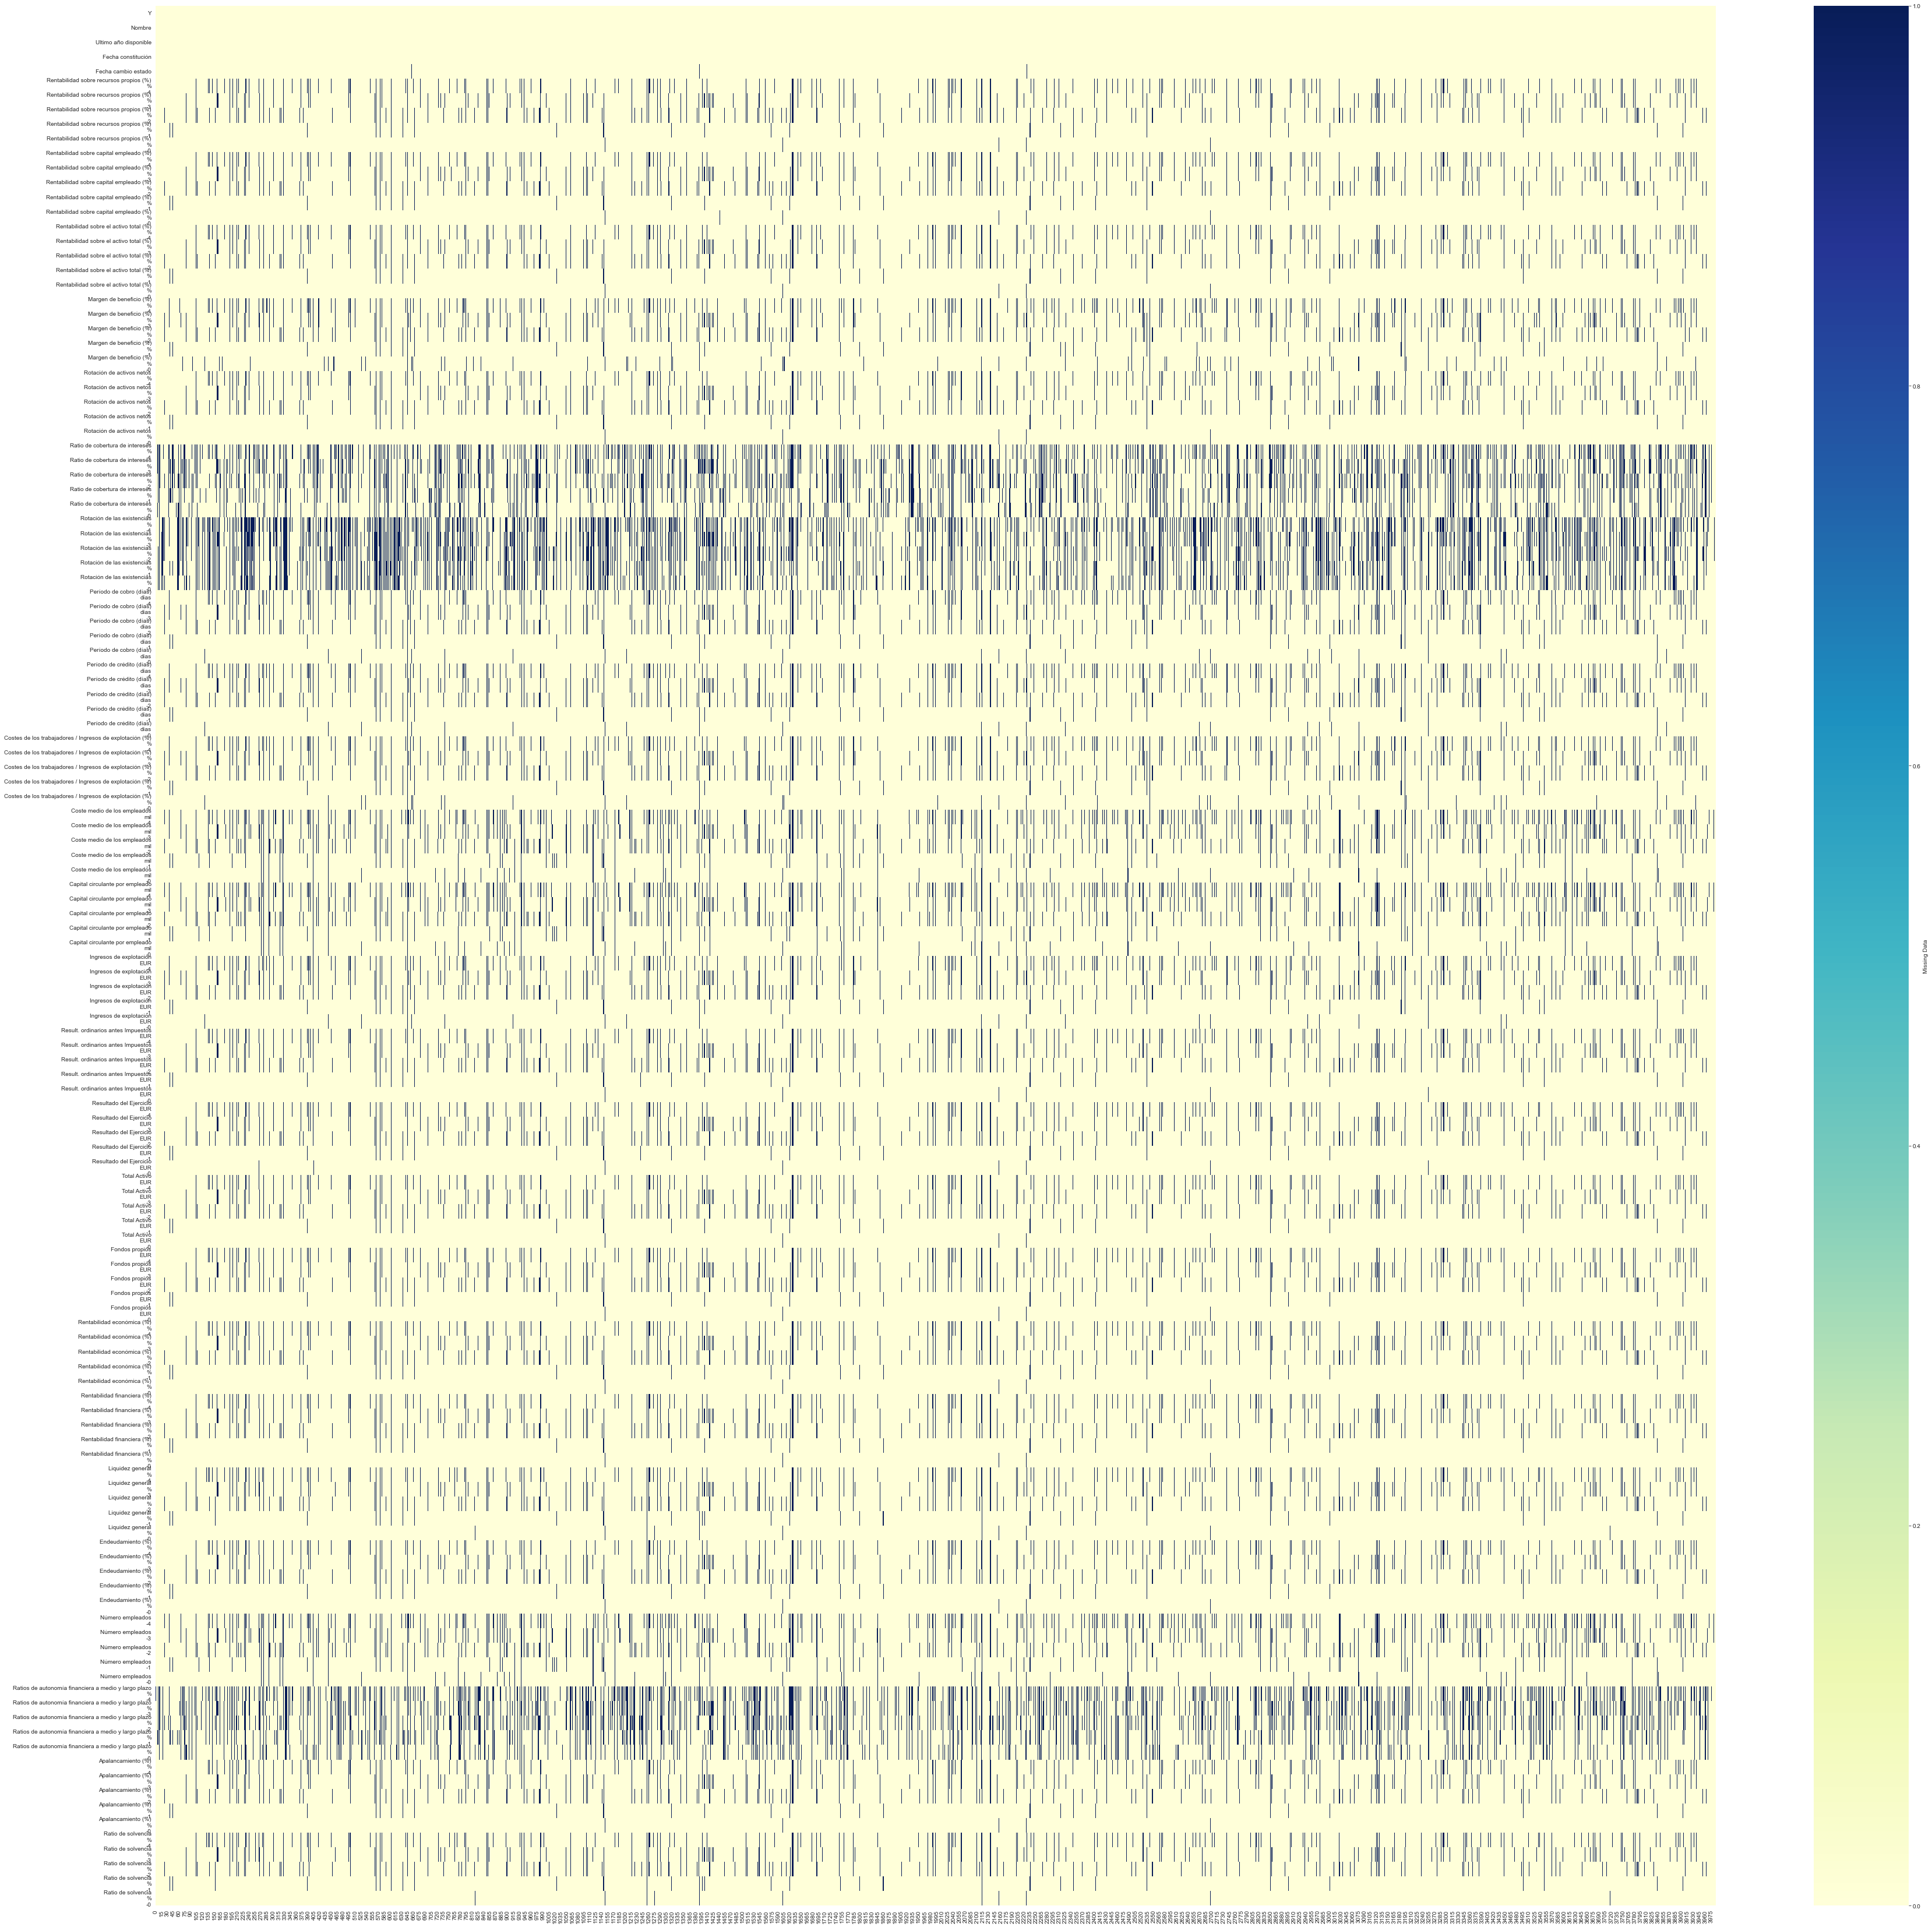

In [20]:
import seaborn as sns 
plt.figure(figsize=(60,60))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

In [21]:
df

,Y,Nombre,Ultimo año disponible,Fecha constitución,Fecha cambio estado,Rentabilidad sobre recursos propios (%)\n%\n-4,Rentabilidad sobre recursos propios (%)\n%\n-3,Rentabilidad sobre recursos propios (%)\n%\n-2,Rentabilidad sobre recursos propios (%)\n%\n-1,Rentabilidad sobre recursos propios (%)\n%\n-0,Rentabilidad sobre capital empleado (%)\n%\n-4,Rentabilidad sobre capital empleado (%)\n%\n-3,Rentabilidad sobre capital empleado (%)\n%\n-2,Rentabilidad sobre capital empleado (%)\n%\n-1,Rentabilidad sobre capital empleado (%)\n%\n-0,Rentabilidad sobre el activo total (%)\n%\n-4,Rentabilidad sobre el activo total (%)\n%\n-3,Rentabilidad sobre el activo total (%)\n%\n-2,Rentabilidad sobre el activo total (%)\n%\n-1,Rentabilidad sobre el activo total (%)\n%\n-0,Margen de beneficio (%)\n%\n-4,Margen de beneficio (%)\n%\n-3,Margen de beneficio (%)\n%\n-2,Margen de beneficio (%)\n%\n-1,Margen de beneficio (%)\n%\n-0,Rotación de activos netos\n%\n-4,Rotación de activos netos\n%\n-3,Rotación de activos netos\n%\n-2,Rotación de activos netos\n%\n-1,Rotación de activos netos\n%\n-0,Ratio de cobertura de intereses\n%\n-4,Ratio de cobertura de intereses\n%\n-3,Ratio de cobertura de intereses\n%\n-2,Ratio de cobertura de intereses\n%\n-1,Ratio de cobertura de intereses\n%\n-0,Rotación de las existencias\n%\n-4,Rotación de las existencias\n%\n-3,Rotación de las existencias\n%\n-2,Rotación de las existencias\n%\n-1,Rotación de las existencias\n%\n-0,Período de cobro (días)\ndías\n-4,Período de cobro (días)\ndías\n-3,Período de cobro (días)\ndías\n-2,Período de cobro (días)\ndías\n-1,Período de cobro (días)\ndías\n-0,Período de crédito (días)\ndías\n-4,Período de crédito (días)\ndías\n-3,Período de crédito (días)\ndías\n-2,Período de crédito (días)\ndías\n-1,Período de crédito (días)\ndías\n-0,Costes de los trabajadores / Ingresos de explotación (%)\n%\n-4,Costes de los trabajadores / Ingresos de explotación (%)\n%\n-3,Costes de los trabajadores / Ingresos de explotación (%)\n%\n-2,Costes de los trabajadores / Ingresos de explotación (%)\n%\n-1,Costes de los trabajadores / Ingresos de explotación (%)\n%\n-0,Coste medio de los empleados\nmil\n-4,Coste medio de los empleados\nmil\n-3,Coste medio de los empleados\nmil\n-2,Coste medio de los empleados\nmil\n-1,Coste medio de los empleados\nmil\n-0,Capital circulante por empleado\nmil\n-4,Capital circulante por empleado\nmil\n-3,Capital circulante por empleado\nmil\n-2,Capital circulante por empleado\nmil\n-1,Capital circulante por empleado\nmil\n-0,Ingresos de explotación\nEUR\n-4,Ingresos de explotación\nEUR\n-3,Ingresos de explotación\nEUR\n-2,Ingresos de explotación\nEUR\n-1,Ingresos de explotación\nEUR\n-0,Result. ordinarios antes Impuestos\nEUR\n-4,Result. ordinarios antes Impuestos\nEUR\n-3,Result. ordinarios antes Impuestos\nEUR\n-2,Result. ordinarios antes Impuestos\nEUR\n-1,Result. ordinarios antes Impuestos\nEUR\n-0,Resultado del Ejercicio\nEUR\n-4,Resultado del Ejercicio\nEUR\n-3,Resultado del Ejercicio\nEUR\n-2,Resultado del Ejercicio\nEUR\n-1,Resultado del Ejercicio\nEUR\n-0,Total Activo\nEUR\n-4,Total Activo\nEUR\n-3,Total Activo\nEUR\n-2,Total Activo\nEUR\n-1,Total Activo\nEUR\n-0,Fondos propios\nEUR\n-4,Fondos propios\nEUR\n-3,Fondos propios\nEUR\n-2,Fondos propios\nEUR\n-1,Fondos propios\nEUR\n-0,Rentabilidad económica (%)\n%\n-4,Rentabilidad económica (%)\n%\n-3,Rentabilidad económica (%)\n%\n-2,Rentabilidad económica (%)\n%\n-1,Rentabilidad económica (%)\n%\n-0,Rentabilidad financiera (%)\n%\n-4,Rentabilidad financiera (%)\n%\n-3,Rentabilidad financiera (%)\n%\n-2,Rentabilidad financiera (%)\n%\n-1,Rentabilidad financiera (%)\n%\n-0,Liquidez general\n%\n-4,Liquidez general\n%\n-3,Liquidez general\n%\n-2,Liquidez general\n%\n-1,Liquidez general\n%\n-0,Endeudamiento (%)\n%\n-4,Endeudamiento (%)\n%\n-3,Endeudamiento (%)\n%\n-2,Endeudamiento (%)\n%\n-1,Endeudamiento (%)\n%\n-0,Número empleados\n-4,Número empleados\n-3,Número empleados\n-2,Número empleados\n-1,Número empleados\n-0

In [22]:
df.to_csv('Datos/CNAE55-5años.csv')

## Limpiamos

In [23]:
def rellenarNan(df,n,columnas_anuales,verbose=0):

    df_copia = df.copy()
    extremos = 0
    grupos_3 = 0
    grupos_4 = 0
    grupos_5 = 0

    indices = range(n-1,-1,-1)

    print('------------Rellenando extremos----------')
    # Si hay nan-dato o dato-nan en los extremos, se llena con el dato
    for j in range(len(df)):
        for columna in columnas_anuales:
            if  np.isnan(df.loc[j,columna +'-{}'.format(str(indices[0]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[1]))])==False:
                    df_copia.loc[j,columna +'-{}'.format(str(indices[0]))] = df_copia.loc[j, columna +'-{}'.format(str(indices[1]))]
                    if verbose:
                        print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[0]))],df.loc[j,columna +'-{}'.format(str(indices[1]))])
                    extremos += 1

            if  np.isnan(df.loc[j,columna +'-{}'.format(str(indices[-1]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[-2]))])==False:
                    df_copia.loc[j, columna +'-{}'.format(str(indices[-1]))] = df_copia.loc[j, columna +'-{}'.format(str(indices[-2]))]
                    if verbose:
                        print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[-2]))],df.loc[j,columna +'-{}'.format(str(indices[-1]))])
                    extremos += 1
    
    print('------------Rellenando Dato-NaN-Dato----------')
    # Si hay dato-nan-dato, que se llene con la media
    for j in range(len(df)):
        for columna in columnas_anuales:
            for i in range(len(indices)-3+1):
                if  np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i]))])==False and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+1]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+2]))])==False:
                    df_copia.loc[j,columna +'-{}'.format(str(indices[i+1]))] = (df_copia.loc[j,columna +'-{}'.format(str(indices[i]))] + df_copia.loc[j,columna +'-{}'.format(str(indices[i+2]))])/2
                    if verbose:
                        print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[i]))],df.loc[j,columna +'-{}'.format(str(indices[i+1]))],df.loc[j,columna +'-{}'.format(str(indices[i+2]))])
                    grupos_3 += 1

    # Si hay dato-nan-nan-dato, rellenamos con la progresión lineal
    for j in range(len(df)):
        for columna in columnas_anuales:
            for i in range(len(indices)-4+1):
                if  (np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i]))])==False and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+1]))])==True and np.isnan(df[columna +'-{}'.format(str(indices[i+2]))][j])==True and np.isnan(df[columna +'-{}'.format(str(indices[i+3]))][j])==False):
                    media  = (df.loc[j,columna +'-{}'.format(str(indices[i]))] + df.loc[j,columna +'-{}'.format(str(indices[i+3]))])/2
                    df_copia.loc[j,columna +'-{}'.format(str(indices[i+1]))] = (df.loc[j,columna +'-{}'.format(str(indices[i]))] + media)/2
                    df_copia.loc[j,columna +'-{}'.format(str(indices[i+2]))] = (df.loc[j,columna +'-{}'.format(str(indices[i+3]))] + media)/2
                    if verbose:
                        print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[i]))],df.loc[j,columna +'-{}'.format(str(indices[i+1]))],df.loc[j,columna +'-{}'.format(str(indices[i+2]))],df.loc[j,columna +'-{}'.format(str(indices[i+3]))])
                    grupos_4 += 2

    # Si hay dato-nan-nan-nan-dato, rellenamos el del medio con la media
    for j in range(len(df)):
        for columna in columnas_anuales:
            for i in range(len(indices)-5+1):
                if  (np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i]))])==False and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+1]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+2]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+3]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+4]))])==False):
                    media  = (df.loc[j,columna +'-{}'.format(str(indices[i]))] + df.loc[j,columna +'-{}'.format(str(indices[i+4]))])/2
                    df_copia.loc[j,columna +'-{}'.format(str(indices[i+2]))] = media
                    if verbose:
                        print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[i]))],df.loc[j,columna +'-{}'.format(str(indices[i+1]))],df.loc[j,columna +'-{}'.format(str(indices[i+2]))],df.loc[j,columna +'-{}'.format(str(indices[i+3]))],df.loc[j,columna +'-{}'.format(str(indices[i+4]))])
                    grupos_5 += 1



    if(grupos_5>0):
        df = df_copia
        df_copia = df.copy()
        print('------------Rellenando Dato-NaN-Dato----------')
        # Si hay dato-nan-dato, que se llene con la media
        for j in range(len(df)):
            for columna in columnas_anuales:
                for i in range(len(indices)-3+1):
                    if  np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i]))])==False and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+1]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+2]))])==False:
                        df_copia.loc[j,columna +'-{}'.format(str(indices[i+1]))] = (df_copia.loc[j,columna +'-{}'.format(str(indices[i]))] + df_copia.loc[j,columna +'-{}'.format(str(indices[i+2]))])/2
                        if verbose:
                            print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[i]))],df.loc[j,columna +'-{}'.format(str(indices[i+1]))],df.loc[j,columna +'-{}'.format(str(indices[i+2]))])
                        grupos_3 += 1


    print('Extremos',extremos)
    print('Grupo 3', grupos_3)
    print('Grupo 4',grupos_4)
    print('Grupo 5',grupos_5)
    print('TOTAL',extremos+grupos_3+grupos_4+grupos_5)
    return df_copia



def rellenarNanHaciaAtras(df,n,columnas_anuales):
    df_copia = df.copy()
    rellenados = 0

    print('------------Rellenando hacia atras----------')
    # Si hay nan-dato o dato-nan en los extremos, se llena con el dato
    for j in range(len(df)):
        for columna in columnas_anuales:
            media = 0
            for i in range(n):
                if(media != np.nan):
                    if np.isnan(df.loc[j,columna+'-{}'.format(i)]):
                        df_copia.loc[j,columna+'-{}'.format(i)]=media
                        rellenados += 1
                    else:
                        media = (media + df.loc[j,columna+'-{}'.format(i)])/2
                else:
                    if np.isnan(df.loc[j,columna+'-{}'.format(i)]) == False:
                        media = df.loc[j,columna+'-{}'.format(i)]

    return df_copia

def rellenarNanHaciaAdelante(df,n,columnas_anuales):
    df_copia = df.copy()
    rellenados = 0

    print('------------Rellenando hacia adelante----------')
    # Si hay nan-dato o dato-nan en los extremos, se llena con el dato
    for j in range(len(df)):
        for columna in columnas_anuales:
            media = np.nan
            for i in range(n-1,-1,-1):
                if(media != np.nan):
                    if np.isnan(df.loc[j,columna+'-{}'.format(i)]):
                        df_copia.loc[j,columna+'-{}'.format(i)]=media
                        rellenados += 1
                    else:
                        media = (media + df.loc[j,columna+'-{}'.format(i)])/2
                else:
                    if np.isnan(df.loc[j,columna+'-{}'.format(i)]) == False:
                        media = df.loc[j,columna+'-{}'.format(i)]

    return df_copia

def eliminarFilasVacias(df,n,columnas_anuales,verbose=0):
    df_copia = df.copy()
    eliminados = 0

    print('------------Eliminamos aquellas filas con alguna variable anual completamente vacia, de las no extintas----------')
    
    for j in range(len(df)):
        if df.loc[j,'Y'] == 0:
            ya_eliminada = False
            for columna in columnas_anuales:
                if ya_eliminada == False:
                    vacias = 0
                    for i in range(n):
                        if(np.isnan(df.loc[j,columna+'-{}'.format(i)])):
                            vacias +=1
                    if vacias == n:
                        if verbose:
                            print(j,'-->',repr(columna))
                        df_copia.drop(j,axis=0,inplace=True)
                        eliminados += 1
                        ya_eliminada = True

    print(eliminados)
    df_copia.reset_index(drop=True,inplace=True)
    return df_copia

def limpiar(df,n,columnas_anuales,verbose=0):

    # Eliminamos aquellas filas (cuya etiqueta sea '0'), que para alguna variable anualizada tenga todos los valores vacios
    df = eliminarFilasVacias(df,n,columnas_anuales,verbose)
    # Rellenamos aquellos huecos que permitan extrapolar algo (grupos de 3, 4 y 5)
    df = rellenarNan(df,n,columnas_anuales,verbose)
    # Rellenamos los valores perdidos hacia atras
    df = rellenarNanHaciaAtras(df,n,columnas_anuales)
    # Rellenamos los valores perdidos hacia delante
    df = rellenarNanHaciaAdelante(df,n,columnas_anuales)

    return df

In [24]:
df = limpiar(df,5,columnas_anuales,verbose=0)

------------Eliminamos aquellas filas con alguna variable anual completamente vacia, de las no extintas----------
788
------------Rellenando extremos----------
------------Rellenando Dato-NaN-Dato----------
------------Rellenando Dato-NaN-Dato----------
Extremos 3891
Grupo 3 4585
Grupo 4 1730
Grupo 5 167
TOTAL 10373
------------Rellenando hacia atras----------
------------Rellenando hacia adelante----------


In [25]:
df

,Y,Nombre,Ultimo año disponible,Fecha constitución,Fecha cambio estado,Rentabilidad sobre recursos propios (%)\n%\n-4,Rentabilidad sobre recursos propios (%)\n%\n-3,Rentabilidad sobre recursos propios (%)\n%\n-2,Rentabilidad sobre recursos propios (%)\n%\n-1,Rentabilidad sobre recursos propios (%)\n%\n-0,Rentabilidad sobre capital empleado (%)\n%\n-4,Rentabilidad sobre capital empleado (%)\n%\n-3,Rentabilidad sobre capital empleado (%)\n%\n-2,Rentabilidad sobre capital empleado (%)\n%\n-1,Rentabilidad sobre capital empleado (%)\n%\n-0,Rentabilidad sobre el activo total (%)\n%\n-4,Rentabilidad sobre el activo total (%)\n%\n-3,Rentabilidad sobre el activo total (%)\n%\n-2,Rentabilidad sobre el activo total (%)\n%\n-1,Rentabilidad sobre el activo total (%)\n%\n-0,Margen de beneficio (%)\n%\n-4,Margen de beneficio (%)\n%\n-3,Margen de beneficio (%)\n%\n-2,Margen de beneficio (%)\n%\n-1,Margen de beneficio (%)\n%\n-0,Rotación de activos netos\n%\n-4,Rotación de activos netos\n%\n-3,Rotación de activos netos\n%\n-2,Rotación de activos netos\n%\n-1,Rotación de activos netos\n%\n-0,Ratio de cobertura de intereses\n%\n-4,Ratio de cobertura de intereses\n%\n-3,Ratio de cobertura de intereses\n%\n-2,Ratio de cobertura de intereses\n%\n-1,Ratio de cobertura de intereses\n%\n-0,Rotación de las existencias\n%\n-4,Rotación de las existencias\n%\n-3,Rotación de las existencias\n%\n-2,Rotación de las existencias\n%\n-1,Rotación de las existencias\n%\n-0,Período de cobro (días)\ndías\n-4,Período de cobro (días)\ndías\n-3,Período de cobro (días)\ndías\n-2,Período de cobro (días)\ndías\n-1,Período de cobro (días)\ndías\n-0,Período de crédito (días)\ndías\n-4,Período de crédito (días)\ndías\n-3,Período de crédito (días)\ndías\n-2,Período de crédito (días)\ndías\n-1,Período de crédito (días)\ndías\n-0,Costes de los trabajadores / Ingresos de explotación (%)\n%\n-4,Costes de los trabajadores / Ingresos de explotación (%)\n%\n-3,Costes de los trabajadores / Ingresos de explotación (%)\n%\n-2,Costes de los trabajadores / Ingresos de explotación (%)\n%\n-1,Costes de los trabajadores / Ingresos de explotación (%)\n%\n-0,Coste medio de los empleados\nmil\n-4,Coste medio de los empleados\nmil\n-3,Coste medio de los empleados\nmil\n-2,Coste medio de los empleados\nmil\n-1,Coste medio de los empleados\nmil\n-0,Capital circulante por empleado\nmil\n-4,Capital circulante por empleado\nmil\n-3,Capital circulante por empleado\nmil\n-2,Capital circulante por empleado\nmil\n-1,Capital circulante por empleado\nmil\n-0,Ingresos de explotación\nEUR\n-4,Ingresos de explotación\nEUR\n-3,Ingresos de explotación\nEUR\n-2,Ingresos de explotación\nEUR\n-1,Ingresos de explotación\nEUR\n-0,Result. ordinarios antes Impuestos\nEUR\n-4,Result. ordinarios antes Impuestos\nEUR\n-3,Result. ordinarios antes Impuestos\nEUR\n-2,Result. ordinarios antes Impuestos\nEUR\n-1,Result. ordinarios antes Impuestos\nEUR\n-0,Resultado del Ejercicio\nEUR\n-4,Resultado del Ejercicio\nEUR\n-3,Resultado del Ejercicio\nEUR\n-2,Resultado del Ejercicio\nEUR\n-1,Resultado del Ejercicio\nEUR\n-0,Total Activo\nEUR\n-4,Total Activo\nEUR\n-3,Total Activo\nEUR\n-2,Total Activo\nEUR\n-1,Total Activo\nEUR\n-0,Fondos propios\nEUR\n-4,Fondos propios\nEUR\n-3,Fondos propios\nEUR\n-2,Fondos propios\nEUR\n-1,Fondos propios\nEUR\n-0,Rentabilidad económica (%)\n%\n-4,Rentabilidad económica (%)\n%\n-3,Rentabilidad económica (%)\n%\n-2,Rentabilidad económica (%)\n%\n-1,Rentabilidad económica (%)\n%\n-0,Rentabilidad financiera (%)\n%\n-4,Rentabilidad financiera (%)\n%\n-3,Rentabilidad financiera (%)\n%\n-2,Rentabilidad financiera (%)\n%\n-1,Rentabilidad financiera (%)\n%\n-0,Liquidez general\n%\n-4,Liquidez general\n%\n-3,Liquidez general\n%\n-2,Liquidez general\n%\n-1,Liquidez general\n%\n-0,Endeudamiento (%)\n%\n-4,Endeudamiento (%)\n%\n-3,Endeudamiento (%)\n%\n-2,Endeudamiento (%)\n%\n-1,Endeudamiento (%)\n%\n-0,Número empleados\n-4,Número empleados\n-3,Número empleados\n-2,Número empleados\n-1,Número empleados\n-0

In [26]:
print('Numero de datos (incluido perdidos):',df.size)
print('Numero de datos perdidos:',df.isnull().values.sum())
print('Porcentaje de datos perdidos:',(df.isnull().values.sum()/df.size)*100.0,'%')

Numero de datos (incluido perdidos): 416000
Numero de datos perdidos: 5
Porcentaje de datos perdidos: 0.001201923076923077 %


Se han rellenado todos los datos perdidos. Ese porcentaje se debe a 3 empresas que no tienen información de 'Fecha de cambio de estado'.

## Calculamos las deltas 𝚫

In [27]:
df_deltas = df.copy()

In [28]:
def calcularDeltas(df,n,columnas_anuales):
    df_nuevo = df.copy()

    indices = range(n-1,-1,-1)

    for columna in columnas_anuales:
        for i in range(len(indices)-1):
            df_nuevo[columna+'delta {}-{}'.format(indices[i],indices[i+1])] = ((df_nuevo[columna+'-{}'.format(indices[i+1])]/df_nuevo[columna+'-{}'.format(indices[i])])-1.0)*100
    
    return df_nuevo

In [29]:
df_deltas = calcularDeltas(df_deltas,5,columnas_anuales)

In [30]:
df_deltas

,Y,Nombre,Ultimo año disponible,Fecha constitución,Fecha cambio estado,Rentabilidad sobre recursos propios (%)\n%\n-4,Rentabilidad sobre recursos propios (%)\n%\n-3,Rentabilidad sobre recursos propios (%)\n%\n-2,Rentabilidad sobre recursos propios (%)\n%\n-1,Rentabilidad sobre recursos propios (%)\n%\n-0,Rentabilidad sobre capital empleado (%)\n%\n-4,Rentabilidad sobre capital empleado (%)\n%\n-3,Rentabilidad sobre capital empleado (%)\n%\n-2,Rentabilidad sobre capital empleado (%)\n%\n-1,Rentabilidad sobre capital empleado (%)\n%\n-0,Rentabilidad sobre el activo total (%)\n%\n-4,Rentabilidad sobre el activo total (%)\n%\n-3,Rentabilidad sobre el activo total (%)\n%\n-2,Rentabilidad sobre el activo total (%)\n%\n-1,Rentabilidad sobre el activo total (%)\n%\n-0,Margen de beneficio (%)\n%\n-4,Margen de beneficio (%)\n%\n-3,Margen de beneficio (%)\n%\n-2,Margen de beneficio (%)\n%\n-1,Margen de beneficio (%)\n%\n-0,Rotación de activos netos\n%\n-4,Rotación de activos netos\n%\n-3,Rotación de activos netos\n%\n-2,Rotación de activos netos\n%\n-1,Rotación de activos netos\n%\n-0,Ratio de cobertura de intereses\n%\n-4,Ratio de cobertura de intereses\n%\n-3,Ratio de cobertura de intereses\n%\n-2,Ratio de cobertura de intereses\n%\n-1,Ratio de cobertura de intereses\n%\n-0,Rotación de las existencias\n%\n-4,Rotación de las existencias\n%\n-3,Rotación de las existencias\n%\n-2,Rotación de las existencias\n%\n-1,Rotación de las existencias\n%\n-0,Período de cobro (días)\ndías\n-4,Período de cobro (días)\ndías\n-3,Período de cobro (días)\ndías\n-2,Período de cobro (días)\ndías\n-1,Período de cobro (días)\ndías\n-0,Período de crédito (días)\ndías\n-4,Período de crédito (días)\ndías\n-3,Período de crédito (días)\ndías\n-2,Período de crédito (días)\ndías\n-1,Período de crédito (días)\ndías\n-0,Costes de los trabajadores / Ingresos de explotación (%)\n%\n-4,Costes de los trabajadores / Ingresos de explotación (%)\n%\n-3,Costes de los trabajadores / Ingresos de explotación (%)\n%\n-2,Costes de los trabajadores / Ingresos de explotación (%)\n%\n-1,Costes de los trabajadores / Ingresos de explotación (%)\n%\n-0,Coste medio de los empleados\nmil\n-4,Coste medio de los empleados\nmil\n-3,Coste medio de los empleados\nmil\n-2,Coste medio de los empleados\nmil\n-1,Coste medio de los empleados\nmil\n-0,Capital circulante por empleado\nmil\n-4,Capital circulante por empleado\nmil\n-3,Capital circulante por empleado\nmil\n-2,Capital circulante por empleado\nmil\n-1,Capital circulante por empleado\nmil\n-0,Ingresos de explotación\nEUR\n-4,Ingresos de explotación\nEUR\n-3,Ingresos de explotación\nEUR\n-2,Ingresos de explotación\nEUR\n-1,Ingresos de explotación\nEUR\n-0,Result. ordinarios antes Impuestos\nEUR\n-4,Result. ordinarios antes Impuestos\nEUR\n-3,Result. ordinarios antes Impuestos\nEUR\n-2,Result. ordinarios antes Impuestos\nEUR\n-1,Result. ordinarios antes Impuestos\nEUR\n-0,Resultado del Ejercicio\nEUR\n-4,Resultado del Ejercicio\nEUR\n-3,Resultado del Ejercicio\nEUR\n-2,Resultado del Ejercicio\nEUR\n-1,Resultado del Ejercicio\nEUR\n-0,Total Activo\nEUR\n-4,Total Activo\nEUR\n-3,Total Activo\nEUR\n-2,Total Activo\nEUR\n-1,Total Activo\nEUR\n-0,Fondos propios\nEUR\n-4,Fondos propios\nEUR\n-3,Fondos propios\nEUR\n-2,Fondos propios\nEUR\n-1,Fondos propios\nEUR\n-0,Rentabilidad económica (%)\n%\n-4,Rentabilidad económica (%)\n%\n-3,Rentabilidad económica (%)\n%\n-2,Rentabilidad económica (%)\n%\n-1,Rentabilidad económica (%)\n%\n-0,Rentabilidad financiera (%)\n%\n-4,Rentabilidad financiera (%)\n%\n-3,Rentabilidad financiera (%)\n%\n-2,Rentabilidad financiera (%)\n%\n-1,Rentabilidad financiera (%)\n%\n-0,Liquidez general\n%\n-4,Liquidez general\n%\n-3,Liquidez general\n%\n-2,Liquidez general\n%\n-1,Liquidez general\n%\n-0,Endeudamiento (%)\n%\n-4,Endeudamiento (%)\n%\n-3,Endeudamiento (%)\n%\n-2,Endeudamiento (%)\n%\n-1,Endeudamiento (%)\n%\n-0,Número empleados\n-4,Número empleados\n-3,Número empleados\n-2,Número empleados\n-1,Número empleados\n-0

In [31]:
print('Numero de datos (incluido perdidos):',df_deltas.size)
print('Numero de datos perdidos:',df_deltas.isnull().values.sum())
print('Porcentaje de datos perdidos:',(df_deltas.isnull().values.sum()/df.size)*100.0,'%')

Numero de datos (incluido perdidos): 736000
Numero de datos perdidos: 3931
Porcentaje de datos perdidos: 0.944951923076923 %


-problema cuando hay un 0 en el denominador

In [32]:
pd.options.mode.use_inf_as_na = True
df_deltas.fillna(value=0.0,inplace=True)

In [33]:
print('Numero de datos (incluido perdidos):',df_deltas.size)
print('Numero de datos perdidos:',df_deltas.isnull().values.sum())
print('Porcentaje de datos perdidos:',(df_deltas.isnull().values.sum()/df.size)*100.0,'%')

Numero de datos (incluido perdidos): 736000
Numero de datos perdidos: 0
Porcentaje de datos perdidos: 0.0 %


# Imbalanced Learning

In [34]:
X = df
Y = df['Y']
X.drop('Y',inplace=True,axis=1)

X.drop(['Nombre','Ultimo año disponible','Fecha constitución','Fecha cambio estado'],inplace=True,axis=1)

In [35]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.33)

In [36]:
print('Conjunto de entrenamiento %s' % Counter(Y_train))
print('Conjunto de prueba %s' % Counter(Y_test))

Conjunto de entrenamiento Counter({0: 1900, 1: 244})
Conjunto de prueba Counter({0: 930, 1: 126})


## Baseline

Buscando (SVM)
Mejores parametros: {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 88.07% test recall 0.00% test precision 0.00%
Buscando (RandomForest)
Mejores parametros: {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 200, 'random_state': 42}
test acurracy 89.49% test recall 13.49% test precision 89.47%
Buscando (xgBoost)
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 90.06% test recall 26.19% test precision 73.33%


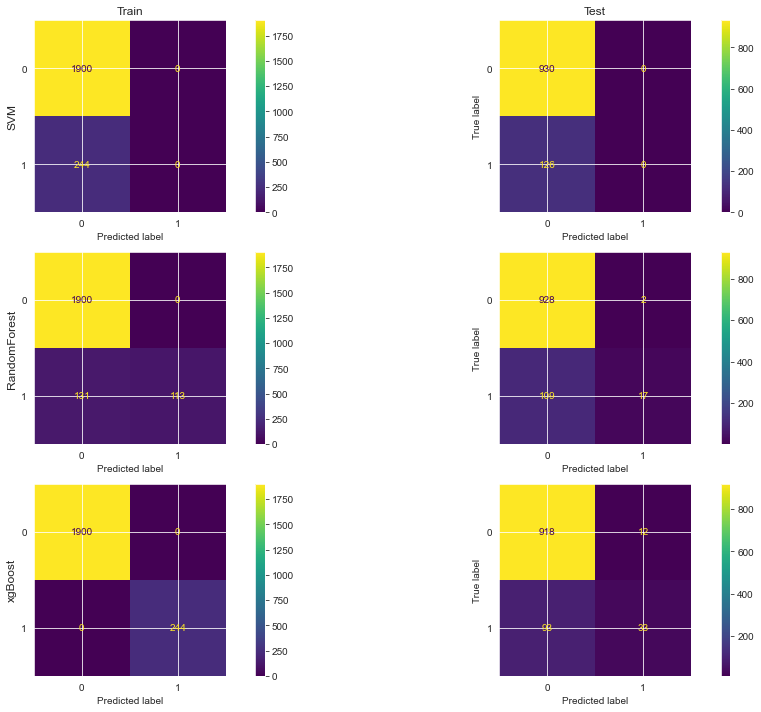

In [37]:
### APARECIDOS
param_svm = {
    'C' : [0.0001],
    'kernel': ['rbf'],
    'gamma' :[0.0001]
}


param_rf = {
    'n_estimators':[200],
    'max_depth' : [7],
    'criterion' : ['gini'],
    'random_state': [42]
}


param_xgb = {
    'max_depth' : [7],
    'learning_rate' : [0.1],
    'n_estimators' : [300],
    'gamma' : [0],
    'reg_alpha' : [0.1],
    'random_state': [42]
}



modelos = ['SVM','RandomForest','xgBoost']
estimators = [SVC(),RandomForestClassifier(),xgboost.XGBClassifier()]
parametros = [param_svm,param_rf,param_xgb]
entrenados_base = []



fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))

for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):
    busqueda = GridSearchCV(estimador,params,scoring='accuracy',refit=True,n_jobs=-1)
    busqueda.fit(X_train,Y_train)
    print('Buscando ({})'.format(modelo))
    print('Mejores parametros:',busqueda.best_params_)
    print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(busqueda.score(X_test,Y_test),
                                                                                    recall_score(Y_test,busqueda.predict(X_test)),
                                                                                    precision_score(Y_test,busqueda.predict(X_test))))

    plot_confusion_matrix(busqueda, 
                        X_train,
                        Y_train, 
                        ax=axes[ind,0])
    #axes[ind,0].title.set_text('Train')

    plot_confusion_matrix(busqueda, 
                        X_test, 
                        Y_test, 
                        ax=axes[ind,1])
    #axes[ind,1].title.set_text('Test')

    entrenados_base.append(busqueda)

for ax,col in zip(axes[0],['Train','Test']):
    ax.set_title(col)
for ax, row in zip(axes[:,0], modelos):
    ax.set_ylabel(row, rotation=90, size='large')

fig.tight_layout()  
plt.show()

## Baseline DELTAS

In [38]:
X_deltas = df_deltas
Y_deltas = df_deltas['Y']
X_deltas.drop('Y',inplace=True,axis=1)

X_deltas.drop(['Nombre','Ultimo año disponible','Fecha constitución','Fecha cambio estado'],inplace=True,axis=1)

Buscando (SVM)
Mejores parametros: {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 88.07% test recall 0.00% test precision 0.00%
Buscando (RandomForest)
Mejores parametros: {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 200, 'random_state': 42}
test acurracy 89.58% test recall 14.29% test precision 90.00%
Buscando (xgBoost)
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 90.44% test recall 33.33% test precision 71.19%


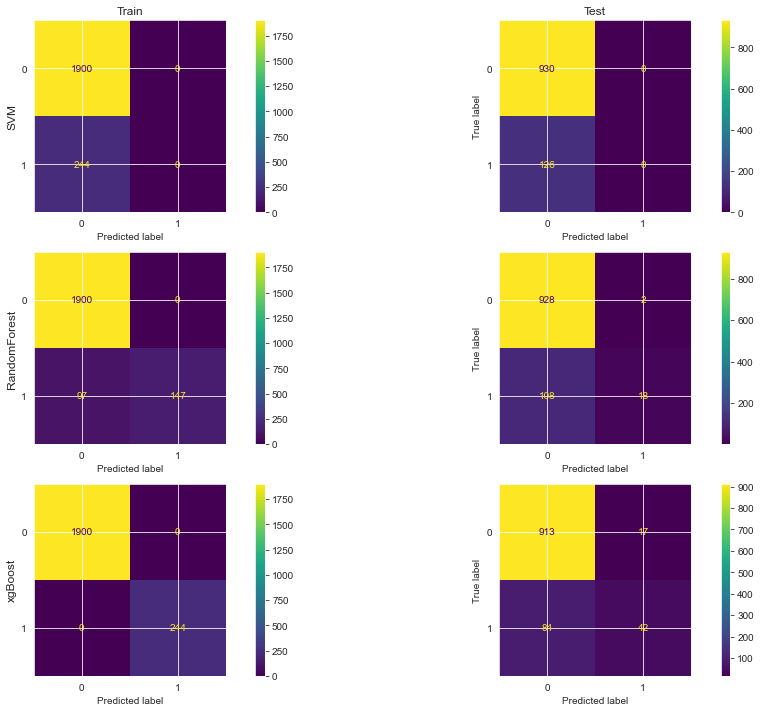

In [39]:
### APARECIDOS
param_svm = {
    'C' : [0.0001],
    'kernel': ['rbf'],
    'gamma' :[0.0001]
}


param_rf = {
    'n_estimators':[200],
    'max_depth' : [7],
    'criterion' : ['gini'],
    'random_state': [42]
}


param_xgb = {
    'max_depth' : [7],
    'learning_rate' : [0.1],
    'n_estimators' : [300],
    'gamma' : [0],
    'reg_alpha' : [0.1],
    'random_state': [42]
}



modelos = ['SVM','RandomForest','xgBoost']
estimators = [SVC(),RandomForestClassifier(),xgboost.XGBClassifier()]
parametros = [param_svm,param_rf,param_xgb]
entrenados_delta_base = []



fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))
X_train_deltas,X_test_deltas,Y_train_deltas,Y_test_deltas = train_test_split(X_deltas,Y_deltas,test_size=0.33)

for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):
    busqueda = GridSearchCV(estimador,params,scoring='accuracy',refit=True,n_jobs=-1)
    busqueda.fit(X_train_deltas,Y_train_deltas)
    print('Buscando ({})'.format(modelo))
    print('Mejores parametros:',busqueda.best_params_)
    print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(busqueda.score(X_test_deltas,Y_test_deltas),
                                                                                    recall_score(Y_test_deltas,busqueda.predict(X_test_deltas)),
                                                                                    precision_score(Y_test_deltas,busqueda.predict(X_test_deltas))))

    plot_confusion_matrix(busqueda,
                        X_train_deltas,
                        Y_train_deltas,
                        ax=axes[ind,0])
    #axes[ind,0].title.set_text('Train')

    plot_confusion_matrix(busqueda,
                        X_test_deltas,
                        Y_test_deltas,
                        ax=axes[ind,1])
    #axes[ind,1].title.set_text('Test')

    entrenados_delta_base.append(busqueda)

for ax,col in zip(axes[0],['Train','Test']):
    ax.set_title(col)
for ax, row in zip(axes[:,0], modelos):
    ax.set_ylabel(row, rotation=90, size='large')

fig.tight_layout()
plt.show()

Lo haremos de dos maneras:


*   Una optimista, donde simplemente separaremos train-test y luego utilizaremos los distintos algoritmos de oversampling sobre el conjunto de train. A lo hora de hiperparametrizar, cada fold tendra las nuevas muestras, incluido el fold usado como validación, por lo que puede haber filtrado de información, y por lo tanto, obtenerse valores mejores a los reales.
*   Utilizando un pipeline de imblearn, que aplica los algoritmos de oversampling solo sobre la parte que se usa para entrenar, no sobre los folds de validación.

https://www.researchgate.net/publication/328315720_Cross-Validation_for_Imbalanced_Datasets_Avoiding_Overoptimistic_and_Overfitting_Approaches

https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html



## Oversampling - Optimista

ROSE
Conjunto de entrenamiento (resampleado) Counter({0: 1900, 1: 1900})
Conjunto de prueba Counter({0: 930, 1: 126})
SVM
Mejores parametros: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 88.07% test recall 0.00% test precision 0.00%
RandomForest
Mejores parametros: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 150, 'random_state': 42}
test acurracy 87.41% test recall 51.59% test precision 47.45%
xgBoost
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 250, 'random_state': 42, 'reg_alpha': 0.01}
test acurracy 91.00% test recall 39.68% test precision 72.46%


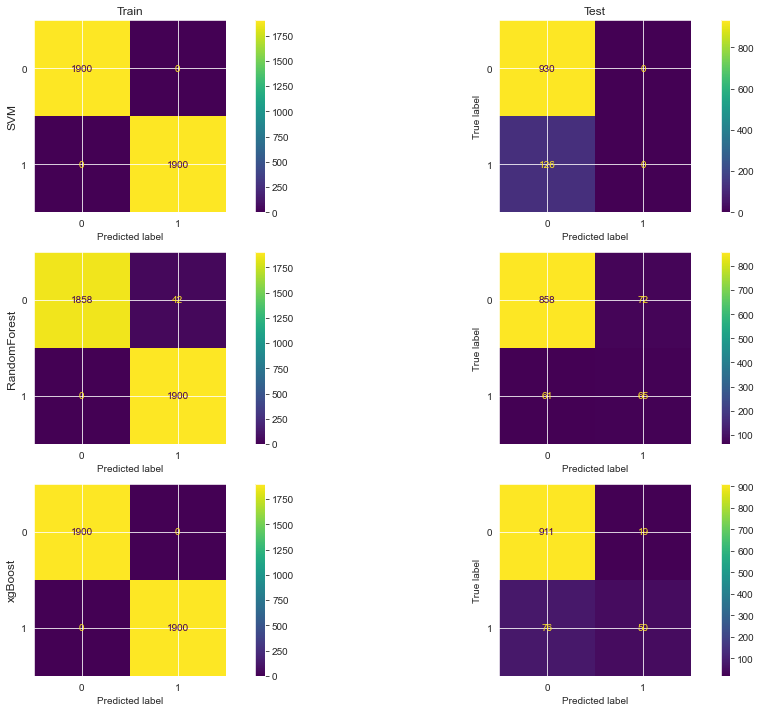

ADASYN
Conjunto de entrenamiento (resampleado) Counter({1: 1938, 0: 1900})
Conjunto de prueba Counter({0: 930, 1: 126})
SVM
Mejores parametros: {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 11.93% test recall 100.00% test precision 11.93%
RandomForest
Mejores parametros: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
test acurracy 81.44% test recall 68.25% test precision 35.54%
xgBoost
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'random_state': 42, 'reg_alpha': 0.01}
test acurracy 87.69% test recall 42.86% test precision 48.21%


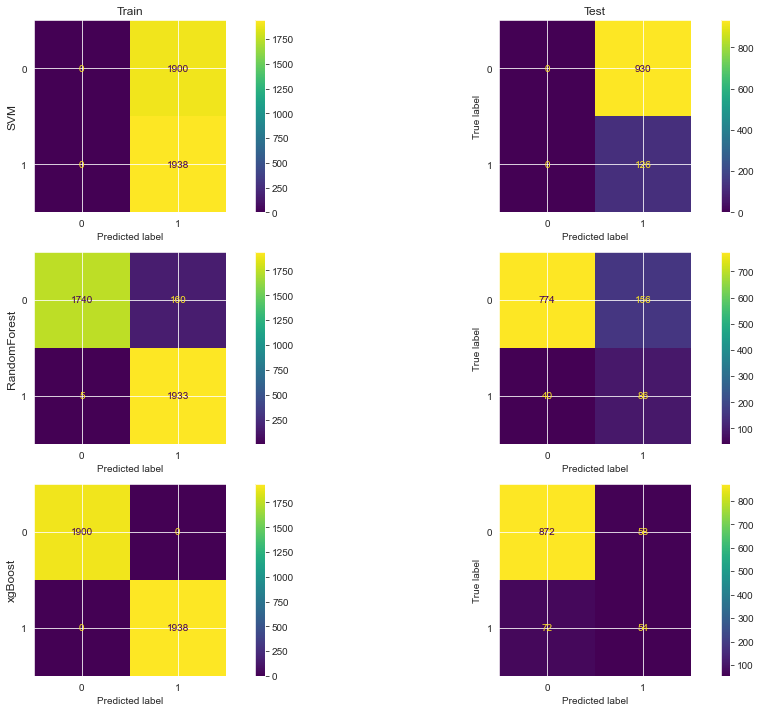

SMOTE
Conjunto de entrenamiento (resampleado) Counter({0: 1900, 1: 1900})
Conjunto de prueba Counter({0: 930, 1: 126})
SVM
Mejores parametros: {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 88.07% test recall 0.00% test precision 0.00%
RandomForest
Mejores parametros: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 150, 'random_state': 42}
test acurracy 82.01% test recall 61.11% test precision 35.32%
xgBoost
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'random_state': 42, 'reg_alpha': 0.01}
test acurracy 87.41% test recall 47.62% test precision 47.24%


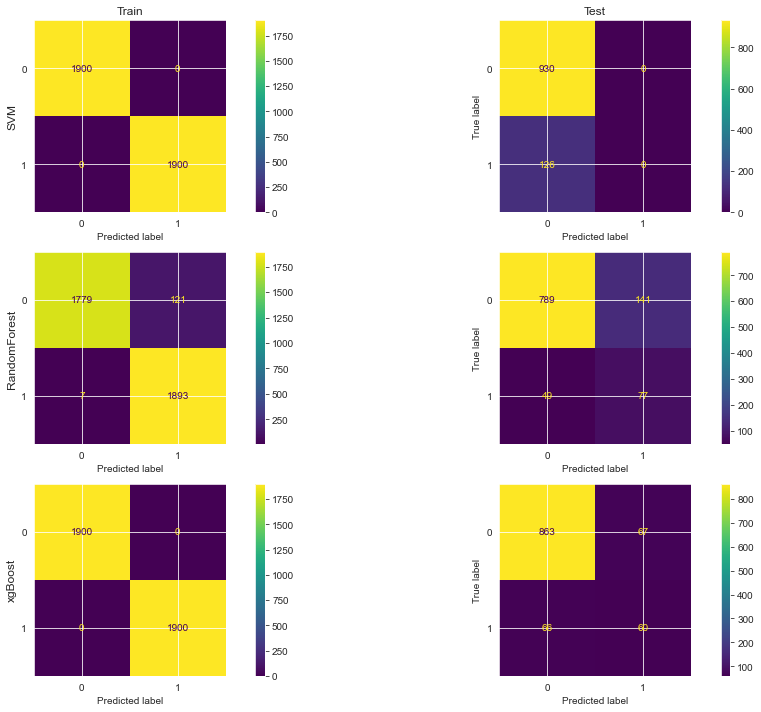

In [40]:
### APARECIDOS
param_svm = {
    'C' : [0.0001,1],
    'kernel': ['rbf'],
    'gamma' :[0.0001,0.005]
}


param_rf = {
    'n_estimators':[150,300],
    'max_depth' : [8],
    'criterion' : ['entropy','gini'],
    'random_state': [42]
}


param_xgb = {
    'max_depth' : [5,6,7],
    'learning_rate' : [0.1],
    'n_estimators' : [250,300],
    'gamma' : [0],
    'reg_alpha' : [0.01],
    'random_state': [42]
}

modelos = ['SVM','RandomForest','xgBoost']
estimators = [SVC(),RandomForestClassifier(),xgboost.XGBClassifier()]
parametros = [param_svm,param_rf,param_xgb]
oversampling = [RandomOverSampler(),ADASYN(),SMOTE()]
oversamplers = ['ROSE','ADASYN','SMOTE']
entrenados = []

for algo,sampler in zip(oversampling,oversamplers):
    fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))
    print(sampler)
    X_res, y_res = algo.fit_resample(X_train, Y_train)
    print('Conjunto de entrenamiento (resampleado) %s' % Counter(y_res))
    print('Conjunto de prueba %s' % Counter(Y_test))

    for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):
        
        busqueda = GridSearchCV(estimador,params,scoring='accuracy',refit=True,n_jobs=-1)
        busqueda.fit(X_res,y_res)
        print(modelo)
        print('Mejores parametros:',busqueda.best_params_)
        print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(busqueda.score(X_test,Y_test),
                                                                                     recall_score(Y_test,busqueda.predict(X_test)),
                                                                                     precision_score(Y_test,busqueda.predict(X_test))))

        plot_confusion_matrix(busqueda, 
                            X_res, 
                            y_res, 
                            ax=axes[ind,0])
        #axes[ind,0].title.set_text('Train')

        plot_confusion_matrix(busqueda, 
                            X_test, 
                            Y_test, 
                            ax=axes[ind,1])
        #axes[ind,1].title.set_text('Test')

        entrenados.append(busqueda)

        for ax,col in zip(axes[0],['Train','Test']):
            ax.set_title(col)
        for ax, row in zip(axes[:,0], modelos):
            ax.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()  
    plt.show()

## Oversampling - Pipeline

ROSE
SVM
Mejores parametros: {'svc__C': 0.0001, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
test acurracy 88.07% test recall 0.00% test precision 0.00%
RandomForest
Mejores parametros: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 250, 'randomforestclassifier__random_state': 42}
test acurracy 87.78% test recall 50.00% test precision 48.84%
xgBoost
Mejores parametros: {'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__random_state': 42, 'xgbclassifier__reg_alpha': 0.1}
test acurracy 90.06% test recall 42.06% test precision 62.35%


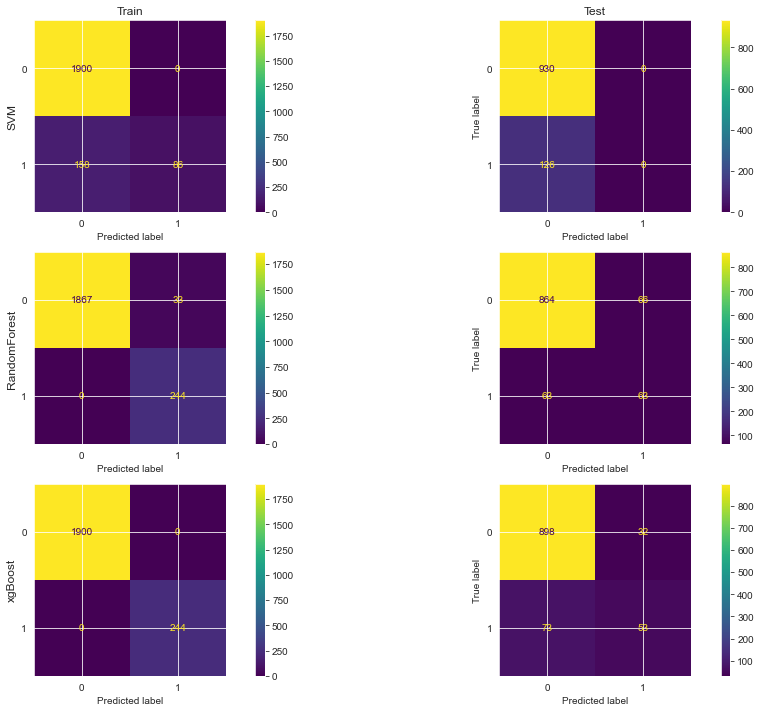

ADASYN
SVM
Mejores parametros: {'svc__C': 0.0001, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
test acurracy 11.93% test recall 100.00% test precision 11.93%
RandomForest
Mejores parametros: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 250, 'randomforestclassifier__random_state': 42}
test acurracy 81.25% test recall 64.29% test precision 34.62%
xgBoost
Mejores parametros: {'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 300, 'xgbclassifier__random_state': 42, 'xgbclassifier__reg_alpha': 0.1}
test acurracy 87.31% test recall 43.65% test precision 46.61%


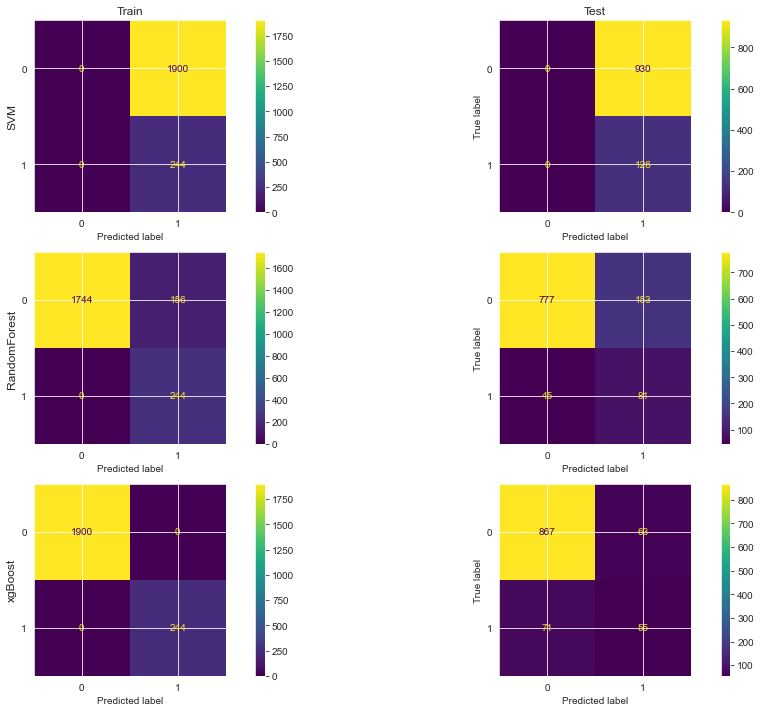

SMOTE
SVM
Mejores parametros: {'svc__C': 1, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
test acurracy 88.07% test recall 0.00% test precision 0.00%
RandomForest
Mejores parametros: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__random_state': 42}
test acurracy 82.20% test recall 63.49% test precision 36.04%
xgBoost
Mejores parametros: {'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 300, 'xgbclassifier__random_state': 42, 'xgbclassifier__reg_alpha': 0.1}
test acurracy 88.16% test recall 47.62% test precision 50.42%


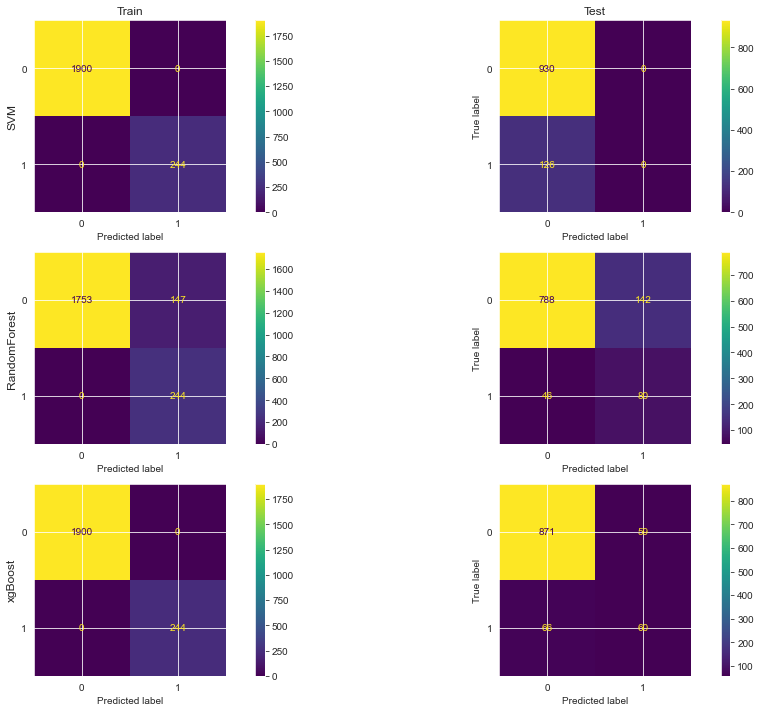

In [41]:
param_svm = {
    'svc__C' : [0.0001,1],
    'svc__kernel': ['rbf'],
    'svc__gamma' : [0.0001]
}


param_rf = {
    'randomforestclassifier__n_estimators':[250,300],
    'randomforestclassifier__max_depth' : [8],
    'randomforestclassifier__criterion' : ['entropy','gini'],
    'randomforestclassifier__random_state': [42]
}


param_xgb = {
    'xgbclassifier__max_depth' : [5,6],
    'xgbclassifier__learning_rate' : [0.1],
    'xgbclassifier__n_estimators' : [200,250,300],
    'xgbclassifier__gamma' : [0],
    'xgbclassifier__reg_alpha' : [0.1],
    'xgbclassifier__random_state': [42]
}


oversampling = [RandomOverSampler(),ADASYN(),SMOTE()]
oversamplers = ['ROSE','ADASYN','SMOTE']
modelos = ['SVM','RandomForest','xgBoost']
estimators = [SVC(),RandomForestClassifier(),xgboost.XGBClassifier()]
parametros = [param_svm,param_rf,param_xgb]
entrenados = []


for algo,sampler in zip(oversampling,oversamplers):
    print(sampler)
    fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))

    for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):
        imblearn_pipeline = make_pipeline(algo, estimador)
        grid_imba = GridSearchCV(imblearn_pipeline, param_grid=params,scoring='accuracy',refit = True,n_jobs=-1)
        grid_imba.fit(X_train, Y_train);
        print(modelo)
        print('Mejores parametros:',grid_imba.best_params_)
        print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(grid_imba.score(X_test,Y_test),
                                                                                     recall_score(Y_test,grid_imba.predict(X_test)),
                                                                                     precision_score(Y_test,grid_imba.predict(X_test))))

        plot_confusion_matrix(grid_imba, 
                            X_train, 
                            Y_train, 
                            ax=axes[ind,0])
        #axes[ind,0].title.set_text('Train')

        plot_confusion_matrix(grid_imba, 
                            X_test, 
                            Y_test, 
                            ax=axes[ind,1])
        #axes[ind,1].title.set_text('Test')

        entrenados.append(busqueda)

    for ax,col in zip(axes[0],['Train','Test']):
        ax.set_title(col)
    for ax, row in zip(axes[:,0], modelos):
        ax.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()  
    plt.show()

## Oversampling DELTAS - Optimista

Con las deltas deberiamos aplicar la funcion de crear las deltas despues del oversampling:

In [42]:
print('Numero de datos perdidos:',df_deltas.isnull().values.sum())

Numero de datos perdidos: 0


In [43]:
X_test_deltas = calcularDeltas(X_test,5,columnas_anuales)
X_test_deltas.fillna(value=0.0,inplace=True)

ROSE
Conjunto de entrenamiento (resampleado) Counter({0: 1900, 1: 1900})
Conjunto de prueba Counter({0: 930, 1: 126})
SVM
Mejores parametros: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 88.07% test recall 0.00% test precision 0.00%
RandomForest
Mejores parametros: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
test acurracy 87.50% test recall 61.90% test precision 48.15%
xgBoost
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 91.00% test recall 42.06% test precision 70.67%


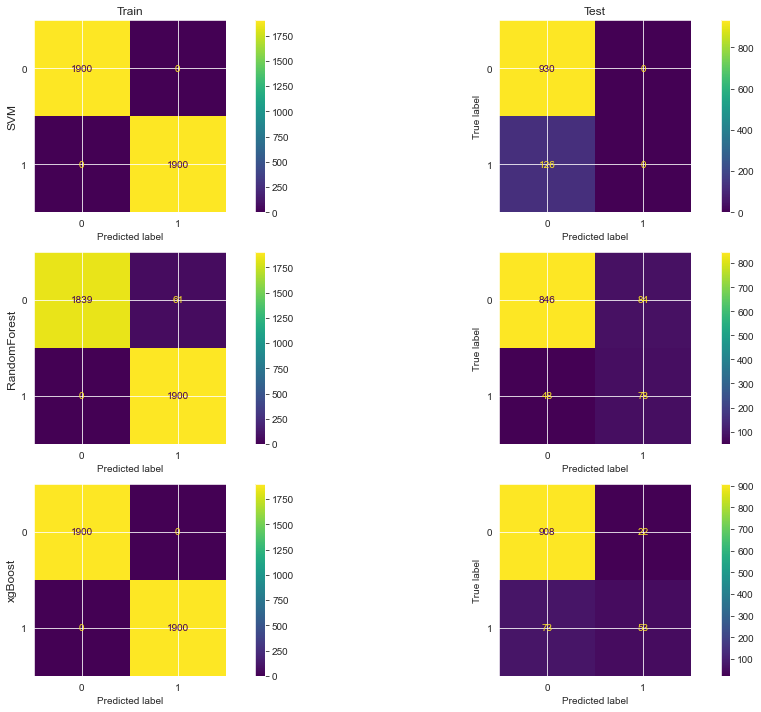

ADASYN
Conjunto de entrenamiento (resampleado) Counter({1: 1938, 0: 1900})
Conjunto de prueba Counter({0: 930, 1: 126})
SVM
Mejores parametros: {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 11.93% test recall 100.00% test precision 11.93%
RandomForest
Mejores parametros: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
test acurracy 82.95% test recall 73.81% test precision 38.75%
xgBoost
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'random_state': 42, 'reg_alpha': 0.01}
test acurracy 88.54% test recall 50.00% test precision 52.07%


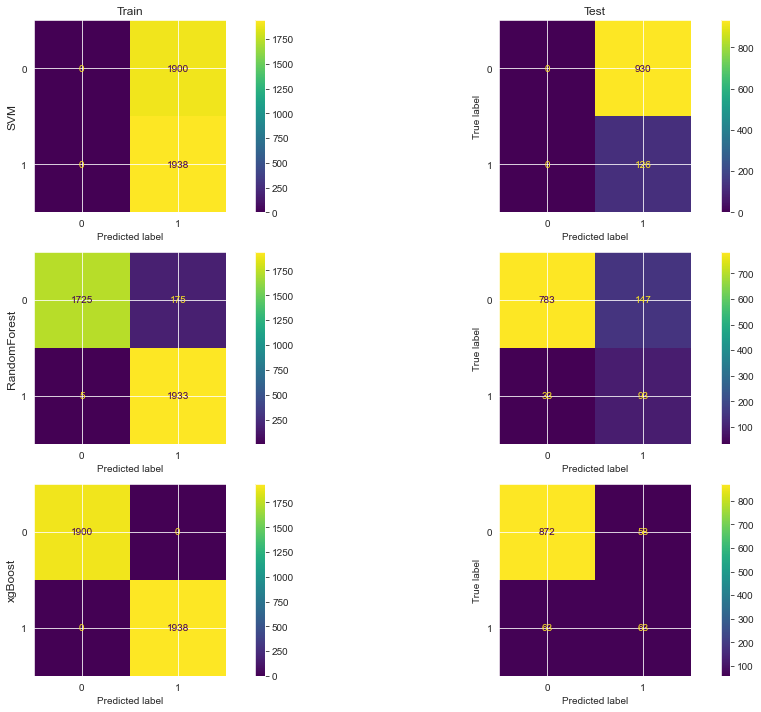

SMOTE
Conjunto de entrenamiento (resampleado) Counter({0: 1900, 1: 1900})
Conjunto de prueba Counter({0: 930, 1: 126})
SVM
Mejores parametros: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 88.07% test recall 0.00% test precision 0.00%
RandomForest
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
test acurracy 82.86% test recall 70.63% test precision 38.20%
xgBoost
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 88.35% test recall 48.41% test precision 51.26%


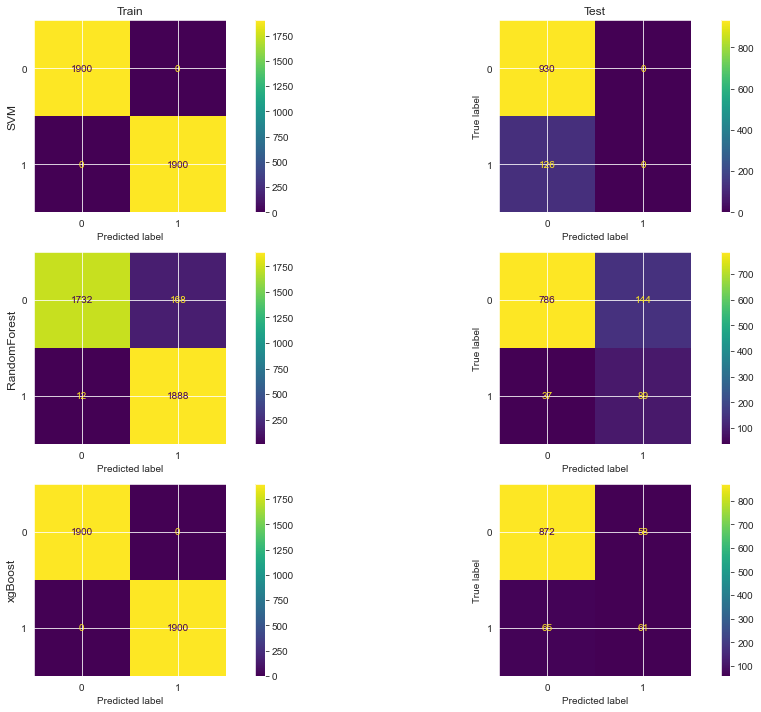

In [44]:
### APARECIDOS
param_svm = {
    'C' : [0.0001,1],
    'kernel': ['rbf'],
    'gamma' :[0.0001]
}


param_rf = {
    'n_estimators':[200,300],
    'max_depth' : [8],
    'criterion' : ['entropy','gini'],
    'random_state': [42]
}


param_xgb = {
    'max_depth' : [5,6],
    'learning_rate' : [0.1],
    'n_estimators' : [250,300],
    'gamma' : [0],
    'reg_alpha' : [0.01,0.1],
    'random_state': [42]
}

modelos = ['SVM','RandomForest','xgBoost']
estimators = [SVC(),RandomForestClassifier(),xgboost.XGBClassifier()]
parametros = [param_svm,param_rf,param_xgb]
oversampling = [RandomOverSampler(),ADASYN(),SMOTE()]
oversamplers = ['ROSE','ADASYN','SMOTE']
entrenados = []

for algo,sampler in zip(oversampling,oversamplers):
    fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))
    print(sampler)
    X_res, y_res = algo.fit_resample(X_train, Y_train)
    X_res = calcularDeltas(X_res,5,columnas_anuales)
    X_res.fillna(value=0.0,inplace=True)
    print('Conjunto de entrenamiento (resampleado) %s' % Counter(y_res))
    print('Conjunto de prueba %s' % Counter(Y_test))

    for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):
        
        busqueda = GridSearchCV(estimador,params,scoring='accuracy',refit=True,n_jobs=-1)
        busqueda.fit(X_res,y_res)
        print(modelo)
        print('Mejores parametros:',busqueda.best_params_)
        print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(busqueda.score(X_test_deltas,Y_test),
                                                                                     recall_score(Y_test,busqueda.predict(X_test_deltas)),
                                                                                     precision_score(Y_test,busqueda.predict(X_test_deltas))))

        plot_confusion_matrix(busqueda, 
                            X_res, 
                            y_res, 
                            ax=axes[ind,0])
        #axes[ind,0].title.set_text('Train')

        plot_confusion_matrix(busqueda, 
                            X_test_deltas, 
                            Y_test, 
                            ax=axes[ind,1])
        #axes[ind,1].title.set_text('Test')

        entrenados.append(busqueda)

        for ax,col in zip(axes[0],['Train','Test']):
            ax.set_title(col)
        for ax, row in zip(axes[:,0], modelos):
            ax.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()  
    plt.show()

## Oversampling DELTAS - Pipeline

In [45]:
from functools import partial

In [46]:
def infnan(x):
    x.fillna(value=0.0,inplace=True)
    x.replace([np.inf, -np.inf], 0, inplace=True)
    return x

In [47]:
deltasparcial = partial(calcularDeltas,n=5,columnas_anuales=columnas_anuales)

In [48]:
transformer_nan = FunctionTransformer(infnan,validate=False)

In [49]:
transformer = FunctionTransformer(deltasparcial,validate=False)

ROSE
SVM
Mejores parametros: {'svc__C': 0.0001, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
test acurracy 88.07% test recall 0.00% test precision 0.00%
RandomForest
Mejores parametros: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 250, 'randomforestclassifier__random_state': 42}
test acurracy 87.88% test recall 62.70% test precision 49.38%
xgBoost
Mejores parametros: {'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 300, 'xgbclassifier__random_state': 42, 'xgbclassifier__reg_alpha': 0.1}
test acurracy 90.53% test recall 42.86% test precision 65.85%


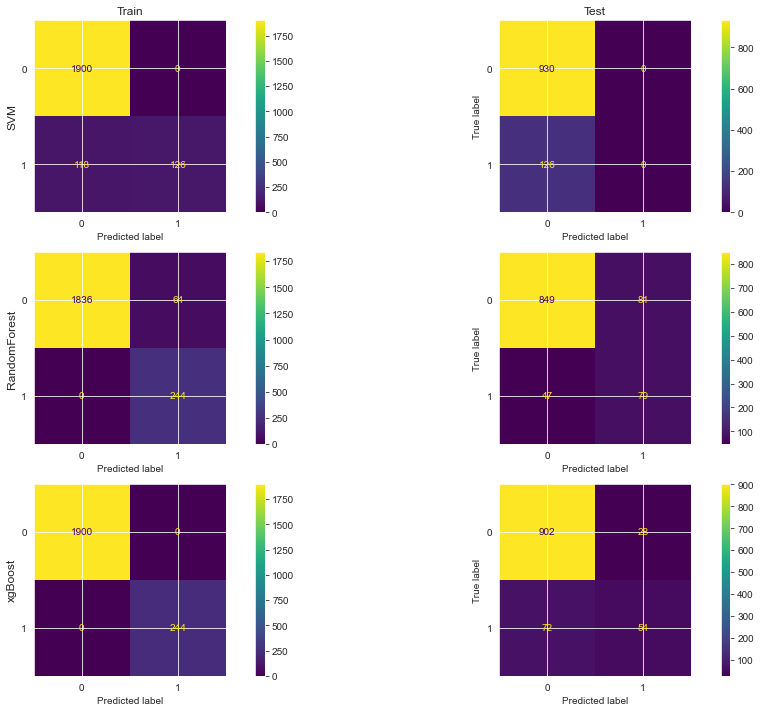

ADASYN
SVM
Mejores parametros: {'svc__C': 0.0001, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
test acurracy 11.93% test recall 100.00% test precision 11.93%
RandomForest
Mejores parametros: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__random_state': 42}
test acurracy 83.14% test recall 71.43% test precision 38.79%
xgBoost
Mejores parametros: {'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 300, 'xgbclassifier__random_state': 42, 'xgbclassifier__reg_alpha': 0.1}
test acurracy 88.35% test recall 48.41% test precision 51.26%


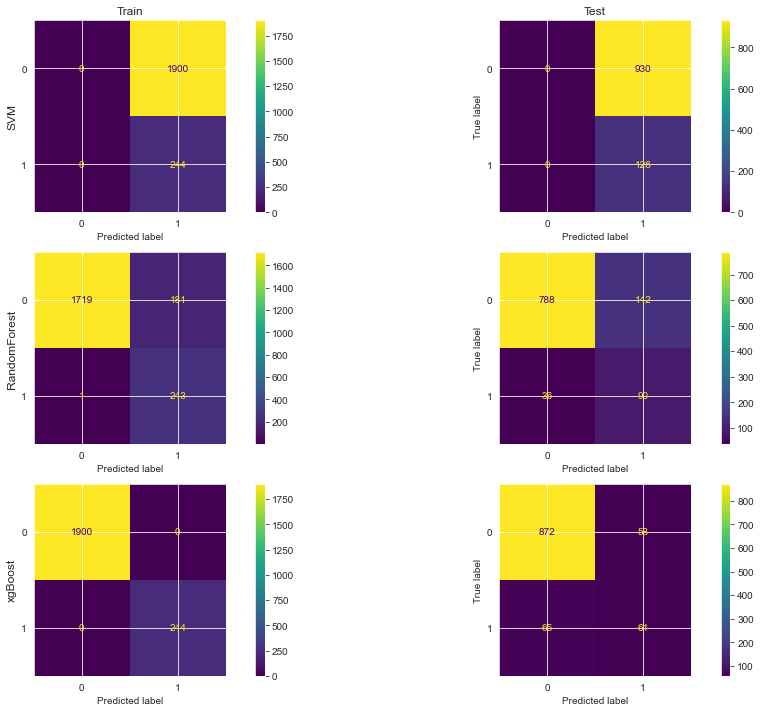

SMOTE
SVM
Mejores parametros: {'svc__C': 1, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
test acurracy 88.07% test recall 0.00% test precision 0.00%
RandomForest
Mejores parametros: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__random_state': 42}
test acurracy 83.43% test recall 73.81% test precision 39.57%
xgBoost
Mejores parametros: {'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 300, 'xgbclassifier__random_state': 42, 'xgbclassifier__reg_alpha': 0.1}
test acurracy 88.35% test recall 50.00% test precision 51.22%


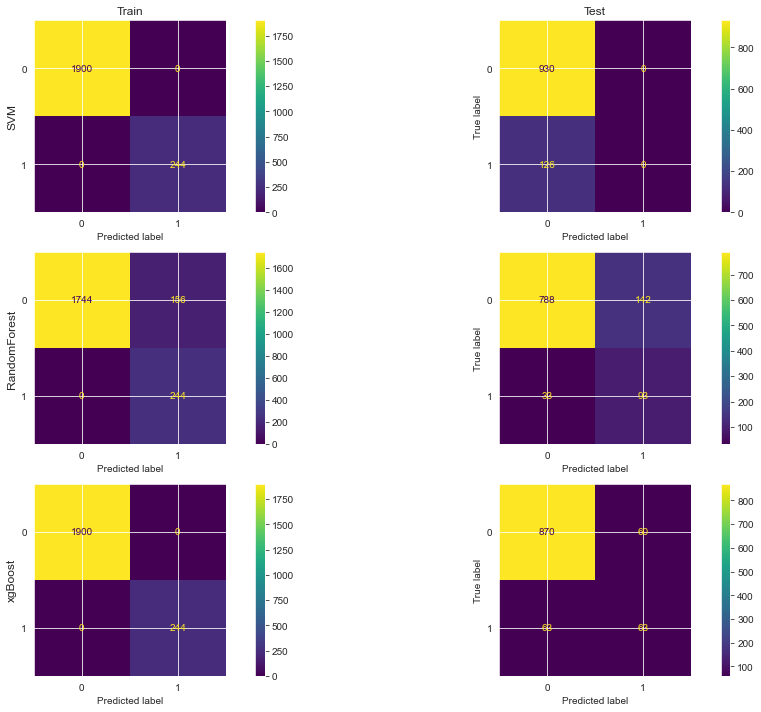

In [50]:
param_svm = {
    'svc__C' : [0.0001,1],
    'svc__kernel': ['rbf'],
    'svc__gamma' : [0.0001]
}


param_rf = {
    'randomforestclassifier__n_estimators':[250,300],
    'randomforestclassifier__max_depth' : [8],
    'randomforestclassifier__criterion' : ['entropy','gini'],
    'randomforestclassifier__random_state': [42]
}


param_xgb = {
    'xgbclassifier__max_depth' : [5,6],
    'xgbclassifier__learning_rate' : [0.1],
    'xgbclassifier__n_estimators' : [200,250,300],
    'xgbclassifier__gamma' : [0],
    'xgbclassifier__reg_alpha' : [0.1],
    'xgbclassifier__random_state': [42]
}


oversampling = [RandomOverSampler(),ADASYN(),SMOTE()]
oversamplers = ['ROSE','ADASYN','SMOTE']
modelos = ['SVM','RandomForest','xgBoost']
estimators = [SVC(),RandomForestClassifier(),xgboost.XGBClassifier()]
parametros = [param_svm,param_rf,param_xgb]
entrenados = []


for algo,sampler in zip(oversampling,oversamplers):
    print(sampler)
    fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))

    for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):
        imblearn_pipeline = make_pipeline(algo,transformer,transformer_nan,estimador)
        grid_imba = GridSearchCV(imblearn_pipeline, param_grid=params,scoring='accuracy',refit = True,n_jobs=-1)
        grid_imba.fit(X_train, Y_train);
        print(modelo)
        print('Mejores parametros:',grid_imba.best_params_)
        print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(grid_imba.score(X_test,Y_test),
                                                                                     recall_score(Y_test,grid_imba.predict(X_test)),
                                                                                     precision_score(Y_test,grid_imba.predict(X_test))))

        plot_confusion_matrix(grid_imba,
                            X_train,
                            Y_train,
                            ax=axes[ind,0])
        #axes[ind,0].title.set_text('Train')

        plot_confusion_matrix(grid_imba,
                            X_test,
                            Y_test,
                            ax=axes[ind,1])
        #axes[ind,1].title.set_text('Test')

        entrenados.append(busqueda)

    for ax,col in zip(axes[0],['Train','Test']):
        ax.set_title(col)
    for ax, row in zip(axes[:,0], modelos):
        ax.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()
    plt.show()

## Combinada - Optimista

SMOTE+Tomek
Conjunto de entrenamiento (resampleado) Counter({0: 1891, 1: 1891})
Conjunto de prueba Counter({0: 930, 1: 126})
SVM
Mejores parametros: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 88.07% test recall 0.00% test precision 0.00%
RandomForest
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
test acurracy 81.25% test recall 65.87% test precision 34.87%
xgBoost
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 250, 'random_state': 42, 'reg_alpha': 0.01}
test acurracy 87.59% test recall 44.44% test precision 47.86%


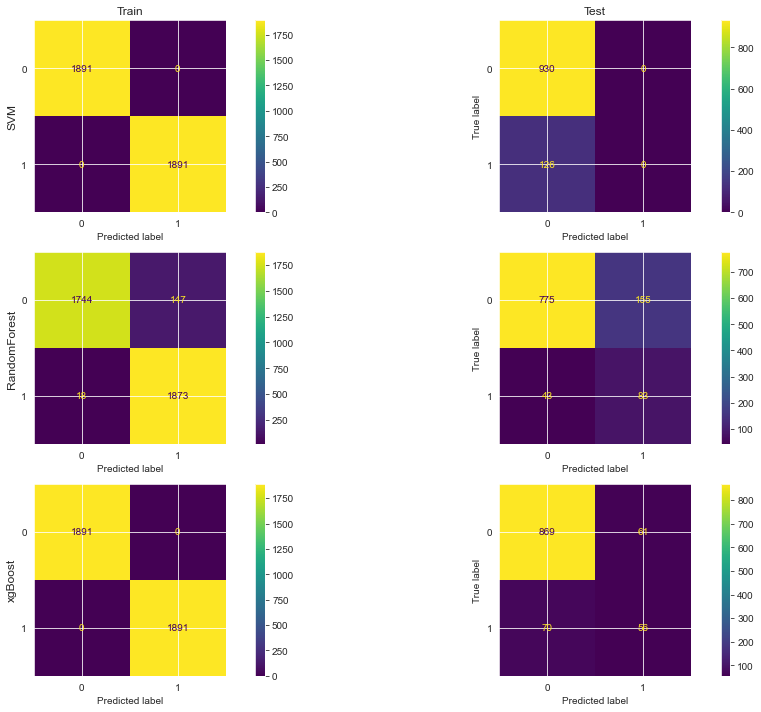

SMOTE+NN
Conjunto de entrenamiento (resampleado) Counter({1: 1820, 0: 1281})
Conjunto de prueba Counter({0: 930, 1: 126})
SVM
Mejores parametros: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 12.12% test recall 100.00% test precision 11.95%
RandomForest
Mejores parametros: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
test acurracy 74.43% test recall 83.33% test precision 29.66%
xgBoost
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250, 'random_state': 42, 'reg_alpha': 0.01}
test acurracy 83.14% test recall 73.81% test precision 39.08%


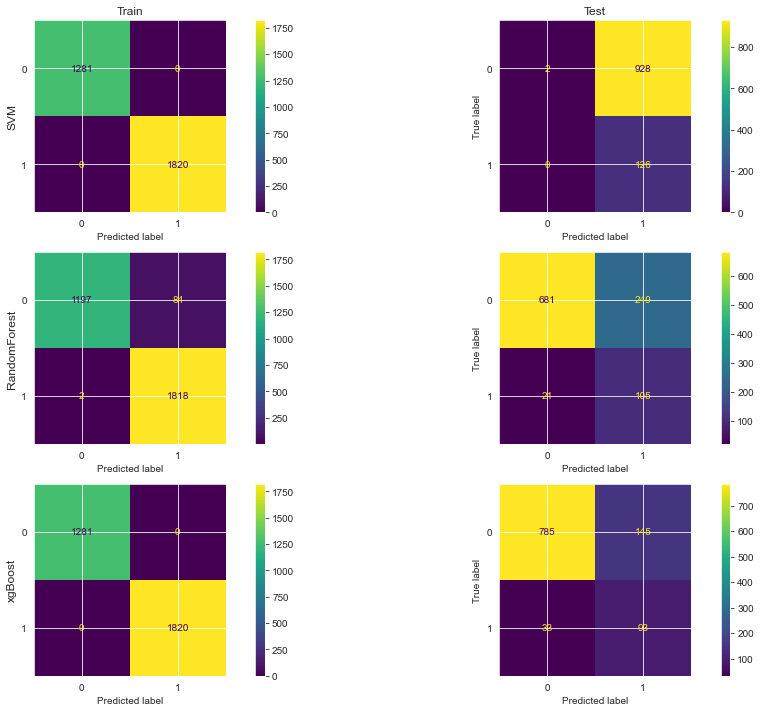

In [51]:
### APARECIDOS
param_svm = {
    'C' : [1],
    'kernel': ['rbf'],
    'gamma' :[0.0001]
}


param_rf = {
    'n_estimators':[300],
    'max_depth' : [8],
    'criterion' : ['gini','entropy'],
    'random_state': [42]
}


param_xgb = {
    'max_depth' : [5,6],
    'learning_rate' : [0.1],
    'n_estimators' : [250],
    'gamma' : [0],
    'reg_alpha' : [0.01,0.1],
    'random_state': [42]
}


modelos = ['SVM','RandomForest','xgBoost']
estimators = [SVC(),RandomForestClassifier(),xgboost.XGBClassifier()]
parametros = [param_svm,param_rf,param_xgb]
oversampling = [SMOTETomek(),SMOTEENN()]
oversamplers = ['SMOTE+Tomek','SMOTE+NN']
entrenados = []

for algo,sampler in zip(oversampling,oversamplers):
    fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))
    print(sampler)
    X_res, y_res = algo.fit_resample(X_train, Y_train)
    print('Conjunto de entrenamiento (resampleado) %s' % Counter(y_res))
    print('Conjunto de prueba %s' % Counter(Y_test))

    for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):

        busqueda = GridSearchCV(estimador,params,scoring='accuracy',refit=True,n_jobs=-1)
        busqueda.fit(X_res,y_res)
        print(modelo)
        print('Mejores parametros:',busqueda.best_params_)
        print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(busqueda.score(X_test,Y_test),
                                                                                     recall_score(Y_test,busqueda.predict(X_test)),
                                                                                     precision_score(Y_test,busqueda.predict(X_test))))

        plot_confusion_matrix(busqueda,
                            X_res,
                            y_res,
                            ax=axes[ind,0])
        #axes[ind,0].title.set_text('Train')

        plot_confusion_matrix(busqueda,
                            X_test,
                            Y_test,
                            ax=axes[ind,1])
        #axes[ind,1].title.set_text('Test')

        entrenados.append(busqueda)

        for ax,col in zip(axes[0],['Train','Test']):
            ax.set_title(col)
        for ax, row in zip(axes[:,0], modelos):
            ax.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()
    plt.show()

## Combinada DELTA - Optimista

SMOTE+Tomek
Conjunto de entrenamiento (resampleado) Counter({0: 1887, 1: 1887})
Conjunto de prueba Counter({0: 930, 1: 126})
SVM
Mejores parametros: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 88.07% test recall 0.00% test precision 0.00%
RandomForest
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
test acurracy 82.29% test recall 71.43% test precision 37.34%
xgBoost
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 87.78% test recall 50.00% test precision 48.84%


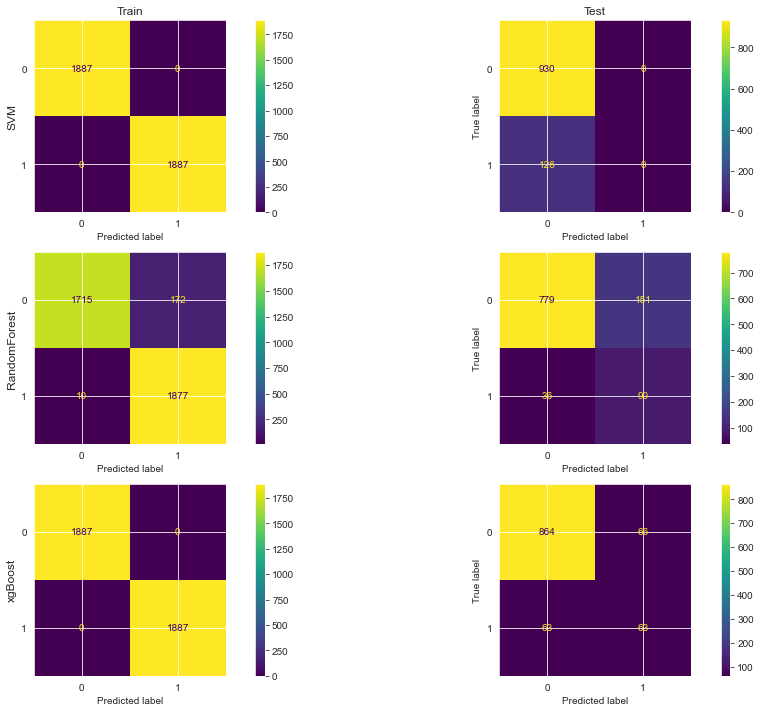

SMOTE+NN
Conjunto de entrenamiento (resampleado) Counter({1: 1802, 0: 1288})
Conjunto de prueba Counter({0: 930, 1: 126})
SVM
Mejores parametros: {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 11.93% test recall 100.00% test precision 11.93%
RandomForest
Mejores parametros: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
test acurracy 76.52% test recall 85.71% test precision 31.95%
xgBoost
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 250, 'random_state': 42, 'reg_alpha': 0.01}
test acurracy 83.81% test recall 76.19% test precision 40.51%


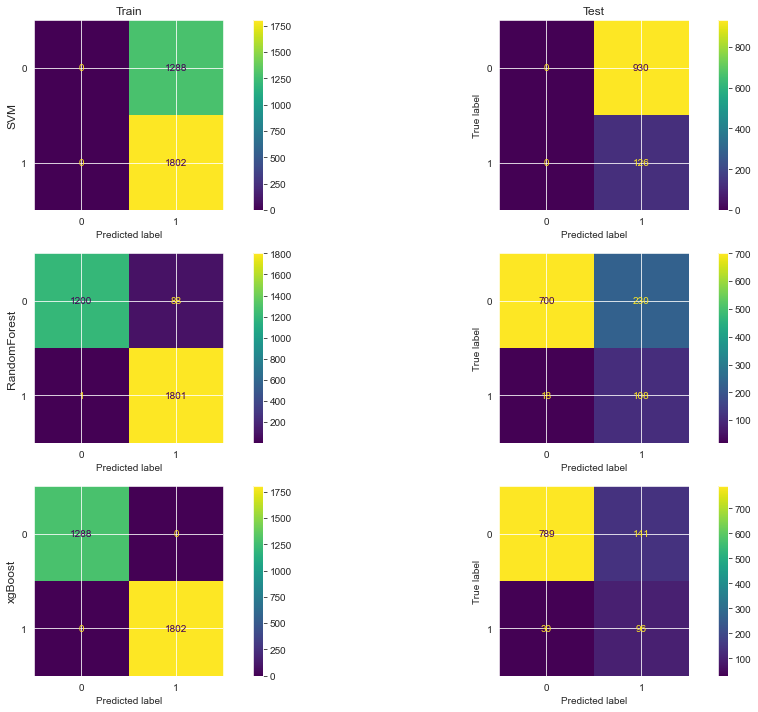

In [52]:
### APARECIDOS
param_svm = {
    'C' : [0.0001,1],
    'kernel': ['rbf'],
    'gamma' :[0.0001]
}


param_rf = {
    'n_estimators':[200,300],
    'max_depth' : [8],
    'criterion' : ['entropy','gini'],
    'random_state': [42]
}


param_xgb = {
    'max_depth' : [5,6],
    'learning_rate' : [0.1],
    'n_estimators' : [250,300],
    'gamma' : [0],
    'reg_alpha' : [0.01,0.1],
    'random_state': [42]
}

modelos = ['SVM','RandomForest','xgBoost']
estimators = [SVC(),RandomForestClassifier(),xgboost.XGBClassifier()]
parametros = [param_svm,param_rf,param_xgb]
oversampling = [SMOTETomek(),SMOTEENN()]
oversamplers = ['SMOTE+Tomek','SMOTE+NN']
entrenados = []

for algo,sampler in zip(oversampling,oversamplers):
    fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))
    print(sampler)
    X_res, y_res = algo.fit_resample(X_train, Y_train)
    X_res = calcularDeltas(X_res,5,columnas_anuales)
    X_res.fillna(value=0.0,inplace=True)
    print('Conjunto de entrenamiento (resampleado) %s' % Counter(y_res))
    print('Conjunto de prueba %s' % Counter(Y_test))

    for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):

        busqueda = GridSearchCV(estimador,params,scoring='accuracy',refit=True,n_jobs=-1)
        busqueda.fit(X_res,y_res)
        print(modelo)
        print('Mejores parametros:',busqueda.best_params_)
        print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(busqueda.score(X_test_deltas,Y_test),
                                                                                     recall_score(Y_test,busqueda.predict(X_test_deltas)),
                                                                                     precision_score(Y_test,busqueda.predict(X_test_deltas))))

        plot_confusion_matrix(busqueda,
                            X_res,
                            y_res,
                            ax=axes[ind,0])
        #axes[ind,0].title.set_text('Train')

        plot_confusion_matrix(busqueda,
                            X_test_deltas,
                            Y_test,
                            ax=axes[ind,1])
        #axes[ind,1].title.set_text('Test')

        entrenados.append(busqueda)

        for ax,col in zip(axes[0],['Train','Test']):
            ax.set_title(col)
        for ax, row in zip(axes[:,0], modelos):
            ax.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()
    plt.show()